In [213]:
from ROOT import TFile,TTree,TH2F
import array
import matplotlib.pyplot as plt
import numpy as np
from root_pandas import read_root 

import scipy.special as spc
import scipy.stats   as stat
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.special import wofz

# Formating

In [214]:
def BinFormat(Bins,Type='ranges'):
    bins = []
    if Type == 'ranges':
        if type(Bins[0]) is np.ndarray or type(Bins[0]) is list:
            bins = Bins
        else:
            for i in np.arange(len(Bins)-1):
                bins.append([Bins[i],Bins[i+1]])
    elif Type == 'edges':
        if type(Bins[0]) is int or type(Bins[0]) is float:
            bins = Bins
        else:
            for b in Bins:
                bins.append(b[0])
            bins.append(Bins[-1][1])
        bins = array.array("f",bins)
        
    return bins

In [215]:
def BinIndex(Data,Low,Max):
    return np.logical_and(np.array(Data) >= Low, np.array(Data) <  Max)

# Template & Fitting

In [216]:
def Exp(x,*arg):
    lamb,x0 = arg
    return np.exp(-lamb*(x-x0))

In [217]:
def RooCMSShape(x,*arg):
    alpha, beta, peak, gamma = arg
    
    erf = spc.erfc((alpha - x)*beta)
    u = (x-peak)*gamma
    
    u = np.exp(-u)   
    #u[u <- 70] = u[u <- 70]*0 + 1e20
    #u[u > 70]  = u[u > 70]*0
    #ind  =  np.logical_and(u>=-70, u<=70)
    #u[ind]     = np.exp(-u[ind])
    
    return erf*u

In [218]:
def G(x, *arg):
    alpha, mean = arg
    """ Return Gaussian line shape at x with HWHM alpha """
    return np.sqrt(np.log(2) / np.pi) / alpha* np.exp(-((x-mean) / alpha)**2 * np.log(2))

In [219]:
def L(x, *arg):
    gamma, mean = arg
    """ Return Lorentzian line shape at x with HWHM gamma """
    return gamma / np.pi / ((x-mean)**2 + gamma**2)

In [220]:
def Voigt(x, *arg):
    alpha, gamma, mean = arg
    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz(((x-mean) + 1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi)

In [221]:
def NLL(*arg,DATA,Temp):
    Model = Temp(*arg)
    return np.sum(Model) - np.sum(DATA*np.log(Model))

def CHI2(*arg,DATA,Temp):
    Model = Temp(*arg)
    DATA[DATA==0] = 1
    SIGMA_2 = (1/DATA + 1/Model)**(-1)
    return np.sum((Model-DATA)**2/SIGMA_2)

In [222]:
def Template(Nsig,Nbkg,Sig,Bkg):
    return Nsig * (Sig/np.sum(Sig)) + Nbkg * (Bkg/np.sum(Bkg))

# FIT

In [223]:
def GoodGuess(i,j,Ni,Nj,tries,p0):
    if   len(p0) == 4:
        ####################################
        if i == 2 or i == 7:
            return False
        else:
            p0 = [np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4]

        ####################################
        if j == Nj-1 or j == Nj-2:
            #p0 = [1e5,   1e3, 1e5,   1e3]
            #p0 = [1e6,   1e6, 1e6,   1e6]
            p0 = [1e2,   2e2, 1e2,   2e2]
        else:
            p0 = [np.random.rand()*1e4,   np.random.rand()*1e3, np.random.rand()*1e3,   np.random.rand()*1e3]
        ####################################
        if tries == 100:
            print('Reach Maximum tries')
            return False
    elif len(p0) == 12:
        ####################################
        if i == 2 or i == 7:
            return False
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                np.random.rand()*60, np.random.rand()*10, np.random.rand()*200,   np.random.rand()*10,
                np.random.rand()*60, np.random.rand()*10, np.random.rand()*200,  np.random.rand()*10
                ]

        ####################################
        if j == Nj-1 or j == Nj-2:
            p0 = [
                    #1e5,   1e5, 1e5,   1e5,
                    1e2,   2e2, 1e2,   2e2,
                    1, -0.1, 1, 0.1,
                    1, -0.1, 1, 0.1
                    ]
        else:
            p0 = [
                np.random.rand()*1e4,   np.random.rand()*1e3, np.random.rand()*1e3,   np.random.rand()*1e3,
                np.random.rand()*60, -np.random.rand()*10, np.random.rand()*200,   np.random.rand()*10,
                np.random.rand()*60, -np.random.rand()*10, np.random.rand()*200,   np.random.rand()*10
                ]
        ####################################
        if tries == 1000:
            print('Reach Maximum tries')
            return False
    elif len(p0) == 14:
        ####################################
        if i == 2 or i == 7:
            return False
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                np.random.rand()*3, np.random.rand()*3, np.random.rand()*120,
                np.random.rand()*0.05, np.random.rand()*3,
                np.random.rand()*3, np.random.rand()*3, np.random.rand()*120,
                np.random.rand()*0.05, np.random.rand()*3,
                ]

        ####################################
        if j == Nj-1 or j == Nj-2:
            p0 = [
                5e3,   13e3, 5,   13,
                2, 2, 87,
                0.03, 0,
                2, 2, 87,
                0.03, 0,
                ]
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                np.random.rand()*3, np.random.rand()*3, np.random.rand()*120,
                np.random.rand()*0.05, np.random.rand()*3,
                np.random.rand()*3, np.random.rand()*3, np.random.rand()*120,
                np.random.rand()*0.05, np.random.rand()*3,
                ]
    elif len(p0) == 18:
        if i == 2 or i == 7:
            return False
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                # Pass
                np.random.rand()*2,   np.random.rand()*2, np.random.rand()*30,
                np.random.rand()*1e5, np.random.rand()*1e5, np.random.rand()*200,   np.random.rand()*10,
                #Fail
                np.random.rand()*2,   np.random.rand()*2, np.random.rand()*60,
                np.random.rand()*1e5, np.random.rand()*1e5, np.random.rand()*200,  np.random.rand()*10
                ]
        ###########################
        if j == Nj-1 or j == Nj-2:
            p0 = [
                    2e4,   5e3, 1e4,   1e3,
                    #Pass
                    1, 1, 20,
                    1, -2, 100,   -0.03,
                    # Fail
                    1, 1, 50,
                    1e2, 1e2, 100,   -0.03,
                    ]
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                # Pass
                np.random.rand()*2,   np.random.rand()*2, np.random.rand()*30,
                np.random.rand()*1e5, np.random.rand()*1e5, np.random.rand()*200,   np.random.rand()*10,
                #Fail
                np.random.rand()*2,   np.random.rand()*2, np.random.rand()*60,
                np.random.rand()*1e5, np.random.rand()*1e5, np.random.rand()*200,  np.random.rand()*10
                ]          

    return p0

# Main Functionality

In [224]:
def Plot(ax,
         Var,
         ranges, bins, color,
         DataMC='mc',
         tempType='KDE'
        ):
    
        
        if type(bins) is np.ndarray or type(bins) is list:
            hist = np.histogram(
                                Var,
                                range    = ranges,
                                bins     = bins,
                                )
            hist = ax.hist(
                            bins[:-1],
                            histtype = 'step',
                            range    = ranges,
                            weights  = hist[0]/np.diff(bins),
                            bins     = bins,
                            color    = color,
                            label    = 'HIST', 
                            )
        else:
            hist = ax.hist(
                            Var,
                            histtype = 'step',
                            range    = ranges,
                            bins     = bins,
                            color    = color,
                            label    = 'HIST', 
                            #density  = True,
                            )
        
        xc = (hist[1][:-1]+hist[1][1:])/2
        hist[0][np.isnan(hist[0])] = 0
        
        #######
        if   tempType == 'KDE':
            try:
                kde       = stat.gaussian_kde(dataset = Var)    
                template  = kde(xc)
                ratio     = np.sum(template)/np.sum(hist[0])
            except:
                template = xc*0
                ratio    = 1
        elif tempType == 'HIST':
                template = hist[0]
                ratio    = 1
            
        
        ax.plot(xc,template/ratio,'k--',label = 'KDE')
        ax.grid(linestyle = '--')
        ax.legend()
        
        return template, ratio

In [225]:
def EffGrid(sample,
            part         = 'dilepton',
            variable     = 'M',
            DataMC       = 'mc',
            samples      = '',
            ProbeType    = 'Pass',
            IDPass       = True,
            ptBins       = array.array("f",[0,20,35,50,90,150,500]), 
            etaBins      = array.array("f",[-2.5,-2,-1.566,-1.4442,-1.0,0,1.0,1.4442,1.566,2,2.5]),
            ranges       = [60,120],
            bins         =  60, # Should be ranges[1]-ranges[0]
            tempType     = 'KDE',
            BinEBEE      = None,
           ):
    #### Array Outputs
    template,ratios = {},{}
    
    ### Eta Bin formating
    etaBinsEBEE    = [[0,1.4442],[1.566,2.5]]
    etaBins,ptBins = BinFormat(etaBins), BinFormat(ptBins)
    etaNBin,ptNBin = len(etaBins),len(ptBins)

    ### Ploting variable
    if ProbeType == "Pass":
        color = 'C0'
    else:
        color = 'C1' 
    
    figx, figy = etaNBin, ptNBin

    fig = plt.figure(figsize=(figy*3,figx*4))
    for j in np.arange(ptNBin):
        if j in BinEBEE:
            etaBINS = etaBinsEBEE
        else:
            etaBINS = etaBins

        template[j],ratios[j] = {},{}
        for i in np.arange(len(etaBINS)):                 
            VAL = sample[part+variable]
            if IDPass:
                if ProbeType == "Pass":
                    Ind = sample["ProbeIDPass"] == True
                    Ind = np.logical_and(Ind,sample["ProbeISOPass"]   == True)
                    Ind = np.logical_and(Ind,sample["ProbeWorstPass"] == True)
                    Ind = np.logical_and(Ind,sample["ProbeSigPass"]   == False)
                else:
                    Ind = sample["ProbeIDPass"] == False
                    Ind = np.logical_or(Ind,sample["ProbeISOPass"]   == False)
                    Ind = np.logical_or(Ind,sample["ProbeWorstPass"] == False)
                    Ind = np.logical_or(Ind,sample["ProbeSigPass"]   == True)
            else:
                if ProbeType == "Pass":
                    Ind = sample["ProbeIDPass"] == True
                else:
                    Ind = sample["ProbeIDPass"] == False    
            
            
            Var = np.array(VAL[Ind])
            Pt  = sample['leptonTwoPt'][Ind]
            Eta = sample['leptonTwoEta'][Ind]

            ptInd  = BinIndex(Pt , ptBins [j][0], ptBins [j][1])
            etaInd = BinIndex(Eta, etaBINS[i][0], etaBINS[i][1])
            Ind    = np.logical_and(ptInd,etaInd)


            ij = ptNBin*i + (j+1)     
            plt.subplot(etaNBin, ptNBin, ij)
            ax = plt.gca()

            TEMP, RATIO = Plot(
                                ax       = ax,
                                Var      = Var[Ind],
                                ranges   = ranges,
                                bins     = bins,
                                color    = color,
                                DataMC   = DataMC,
                                tempType = tempType,
                                )
                    
            template[j][i] = TEMP
            ratios[j][i]   = RATIO
            
        

            if j == 0:
                ax.set_ylabel('Eta ['+str(round(etaBINS[i][0],2))+','+str(round(etaBINS[i][1],2))+']'  )        
            if i == 0:
                ax.set_title('Pt ['+str(ptBins[j][0])+','+str(ptBins[j][1])+']' )
                
    

    
    plt.tight_layout()
    plt.show()
    #fig.savefig('/home/jcordero/CMS/MEH/zee/'+'zee_'+DataMC+'/'+samples+'_'+ProbeType+'_PeakMap.png')
    fig.savefig(figpath+'zee/zee_'+DataMC+samples+'_'+ProbeType+'_PeakMap.png')
    
    return template,ratios

In [226]:
def EffMC(
            sample,
            part      = 'dilepton',
            variable  = 'M',
            ptBins    = array.array("f",[0,20,35,50,90,150,500]), 
            etaBins   = array.array("f",[-2.5,-2,-1.566,-1.4442,-1.0,0,1.0,1.4442,1.566,2,2.5]),
            ranges    = [60,120],
            bins      =  60, # Should be ranges[1]-ranges[0]
            BinEBEE   = None,
            ProbeType = 'Pass',
            ):
    #### Array Outputs
    Yield = {}
    
    ### Eta Bin formating
    etaBinsEBEE    = [[0,1.4442],[1.566,2.5]]
    etaBins,ptBins = BinFormat(etaBins), BinFormat(ptBins)
    etaNBin,ptNBin = len(etaBins),len(ptBins)
    
    for j in np.arange(ptNBin):
        Yield[j] = {}
        if j in BinEBEE:
            etaBINS = etaBinsEBEE
        else:
            etaBINS = etaBins

        #template[j],ratios[j] = {},{}
        for i in np.arange(len(etaBINS)):                 
            VAL = sample[part+variable]
            if ProbeType == "Pass":
                Ind = sample["ProbeIDPass"] == True
                Ind = np.logical_and(Ind,sample["ProbeISOPass"]   == True)
                Ind = np.logical_and(Ind,sample["ProbeWorstPass"] == True)
                Ind = np.logical_and(Ind,sample["ProbeSigPass"]   == True)
            else:
                Ind = sample["ProbeIDPass"] == False
                Ind = np.logical_or(Ind,sample["ProbeISOPass"]   == False)
                Ind = np.logical_or(Ind,sample["ProbeWorstPass"] == False)
                Ind = np.logical_or(Ind,sample["ProbeSigPass"]   == False)
        
            
            
            Var = np.array(VAL[Ind])
            Pt  = sample['leptonTwoPt'][Ind]
            Eta = sample['leptonTwoEta'][Ind]

            ptInd  = BinIndex(Pt , ptBins [j][0], ptBins [j][1])
            etaInd = BinIndex(Eta, etaBINS[i][0], etaBINS[i][1])
            Ind    = np.logical_and(ptInd,etaInd)
            
            Yield[j][i] = np.sum(Ind)
            
    return Yield

# Extract MC

In [227]:
MC = {}
samples = ["DYJets","WJets"]
#samples = ["DYJets"]


var = ["dileptonM",
       "leptonOnePt","leptonOneEta",
       "leptonTwoPt","leptonTwoEta",
       "vetoDY","genIsoPass",
       "ProbeIDPass","ProbeISOPass","ProbeWorstPass","ProbeSigPass",
       #"ProbePass",
       #"TagFromZ","ProbeFromZ",
      ]

dfMC = {}
for s in samples:
    #path = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Efficiency/files_zee/"+NewOld+s+"/"
    path = "/home/jcordero/CMS/data_"+era+"/"+period+"/SMP_ZG/Files/ee/"+NewOld+s+"/"
    fileName = "output_"+s+"_v.root"
    dfMC[s] = read_root(path+fileName,columns = var)

#################
S = "DYJets"
#S = "WJets"
sample = dfMC[S]    

# Extract Data

In [228]:
#era = '2016'
era = '2017'

if era == "2016":
    period = "legacy"
    run = ['C','D','E','G']
elif era == "2017":
    period = "rereco"
    run = ['B','C','D','E','F']

#NewOld = 'New/'
#NewOld = 'TagProbe/'
NewOld = 'TagProbe_noTrig/'

#path = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Efficiency/files_zee/"+NewOld+"SingleElectron/"
path = "/home/jcordero/CMS/data_"+era+"/"+period+"/SMP_ZG/Files/ee/"+NewOld+"SingleElectron/"
figpath = '/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Efficiency/'

#fileName = "output_Electron_"+era+"C_v.root"

files = [path+"output_Electron_"+era+r+"_v.root" for r in run]

var = ["dileptonM",
       "leptonOnePt","leptonOneEta",
       "leptonTwoPt","leptonTwoEta",
       "vetoDY","genIsoPass",
       "ProbeIDPass","ProbeISOPass","ProbeWorstPass","ProbeSigPass",
       #"ProbePass",
       #"TagFromZ","ProbeFromZ",
      ]

In [229]:
files

['/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ee/TagProbe_noTrig/SingleElectron/output_Electron_2017B_v.root',
 '/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ee/TagProbe_noTrig/SingleElectron/output_Electron_2017C_v.root',
 '/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ee/TagProbe_noTrig/SingleElectron/output_Electron_2017D_v.root',
 '/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ee/TagProbe_noTrig/SingleElectron/output_Electron_2017E_v.root',
 '/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ee/TagProbe_noTrig/SingleElectron/output_Electron_2017F_v.root']

In [230]:
Data = {}
###############
for i in np.arange(len(run)):
    print('-----------')
    print(files[i].split('/')[-1])
    
    #df = read_root(files[i],columns= var)
    #print(len(df.ProbeIDPass),np.sum(df.ProbeIDPass == False),np.sum(df.ProbeIDPass == True),np.sum(df.ProbeIDPass == False)/(np.sum(df.ProbeIDPass == True)+np.sum(df.ProbeIDPass == False)))
    
    if i == 0:
        df = read_root(files[i],columns= var)
        #print(len(df.ProbeIDPass),np.sum(df.ProbeIDPass == False),np.sum(df.ProbeIDPass == True),np.sum(df.ProbeIDPass == False)/(np.sum(df.ProbeIDPass == True)+np.sum(df.ProbeIDPass == False)))
    else:
        df = df.append(read_root(files[i],columns= var))
        #print(len(df.ProbeIDPass),np.sum(df.ProbeIDPass == False),np.sum(df.ProbeIDPass == True),np.sum(df.ProbeIDPass == False)/(np.sum(df.ProbeIDPass == True)+np.sum(df.ProbeIDPass == False)))
    

-----------
output_Electron_2017B_v.root
-----------
output_Electron_2017C_v.root
-----------
output_Electron_2017D_v.root
-----------
output_Electron_2017E_v.root
-----------
output_Electron_2017F_v.root


In [231]:

tempType = 'HIST'
#tempType = 'KDE'

#################
#ptBins  = array.array("f",[10,20,35,50,90,150,500])
#ptBins  = array.array("f",[10,20,35,50,500])

#ptBins  = array.array("f",[0,20,35,50,150,500])
#ptBins  = array.array('f',[0, 20,  25,  30,  35,  45,  55,  65,  75,  85,  95,  120,  1000])
ptBins  = array.array('f',[15, 20,  35,  50,  90,  150,  1500])
#ptBins  = array.array('f',[20,  25,  30,  35,  45,  55,  65,  120,  1000])

#ptBins  = array.array('f',[15,20, 35,  50,  65, 90,  130,  1000]) # Hien Binning

ptBins = BinFormat(ptBins)
#################
#etaBins = array.array("f",[-2.5,-2,-1.566,-1.4442,-1.0,0,1.0,1.4442,1.566,2,2.5])
#etaBins = array.array("f",[-2.5,-2,-1.566,-1.4442,0,1.4442,1.566,2,2.5])
etaBins = array.array("f",[-2.5,-1.566,-1.4442,0,1.4442,1.566,2.5])

#etaBins =[
#            [-2.5,-2],[-2,-1.566],[-1.566,-1.4442],[-1.4442,-1.0],[-1.0,0],
#            [0,1.0],[1.0,1.4442],[1.4442,1.566],[1.566,2.0],[2.0,2.5]
#            ]

etaBins = BinFormat(etaBins)
#################
BinEBEE = [len(ptBins)-1]
#################

normalBin = True
#normalBin = False

ranges = [60,120]
if normalBin:
    bins   = int((ranges[1] - ranges[0] )/2)
    step = (ranges[-1]-ranges[0])/float(bins)
    bins = [ranges[0]+step*i for i in range(bins)]
else:
    bins = [60,65,70,75,80,82,84,86,87,88,89,90,91,92,93,94,96,98,100,105,110,115,120]
weight = np.diff(bins)
binMult = 2
xc = (np.array(bins[:-1])+np.array(bins[1:]))/binMult
x = xc




    

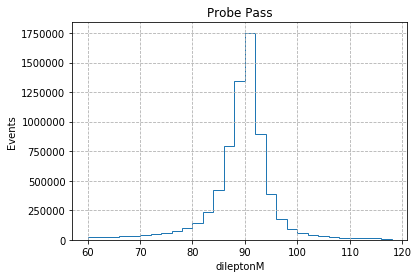

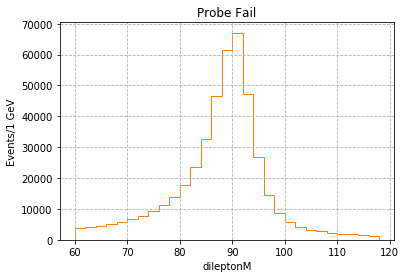

In [232]:
part = "dilepton"
var  = "M"

IDPass    = False
ProbeType = "Pass"
VAR = part+var
if IDPass:
    if ProbeType == "Pass":
        Ind = sample["ProbeIDPass"] == True
        Ind = np.logical_and(Ind,sample["ProbeISOPass"]  == True)
        Ind = np.logical_and(Ind,sample["ProbeWorstass"] == True)
        #Ind = np.logical_and(Ind,sample["ProbeSigPass"]  == True)
    else:
        Ind = sample["ProbeIDPass"] == False
        Ind = np.logical_or(Ind,sample["ProbeISOPass"]  == False)
        Ind = np.logical_or(Ind,sample["ProbeWorstass"] == False)
        #Ind = np.logical_or(Ind,sample["ProbeSigPass"]  == False)
else:
    if ProbeType == "Pass":
        Ind = sample["ProbeIDPass"] == True
    else:
        Ind = sample["ProbeIDPass"] == False 

###############################
Pass = np.histogram(
                np.array(sample[VAR][Ind]),
                range    = ranges,
                bins     = bins,
                )

plt.figure()
plt.hist(
        bins[:-1],
        weights = Pass[0]/weight,
        range    = ranges,
        bins  = bins,
        histtype = 'step',
        color    = 'C0',
        )
plt.grid(linestyle = '--')
plt.ylabel(r'Events')
plt.xlabel(part+var)
plt.title('Probe '+ProbeType  )
plt.show()
###############################

IDPass = True
ProbeType = "Fail"
VAR = part+var
if IDPass:
    if ProbeType == "Pass":
        Ind = sample["ProbeIDPass"] == True
    else:
        Ind = sample["ProbeIDPass"] == False
else:
    if ProbeType == "Pass":
        Ind = sample["ProbeIDISOPass"] == True
    else:
        Ind = sample["ProbeIDISOPass"] == False    
    
Fail = np.histogram(
                np.array(sample[VAR][Ind]),
                range    = ranges,
                bins     = bins,
                )
plt.figure()
plt.hist(
        bins[:-1],
        weights  = Fail[0]/weight,
        range    = ranges,
        bins     = bins,
        histtype = 'step',
        color    = 'C1',
        )

plt.grid(linestyle = '--')
plt.ylabel(r'Events/1 GeV')
plt.xlabel(part+var)
plt.title('Probe '+ProbeType  )
plt.show()

###############################

# MC EFF

In [233]:
PassMC = EffMC(
                sample    = dfMC['DYJets'],
                part      = 'dilepton',
                variable  = 'M',
                ptBins    = ptBins,
                etaBins   = etaBins,
                ranges    = ranges,
                bins      = bins,
                BinEBEE   = BinEBEE,
                ProbeType = 'Pass',
                )

FailMC = EffMC(
                sample    = dfMC['DYJets'],
                part      = 'dilepton',
                variable  = 'M',
                ptBins    = ptBins,
                etaBins   = etaBins,
                ranges    = ranges,
                bins      = bins,
                BinEBEE   = BinEBEE,
                ProbeType = 'Fail',
                )

In [234]:
effMC = {}
for j in  PassMC:
    effMC[j] = {}
    for i in  PassMC[j]:
        effMC[j][i] = PassMC[j][i]/(PassMC[j][i] + FailMC[j][i])

/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [235]:
effMC

{0: {0: 0.6111944725546987,
  1: nan,
  2: 0.7020138955591841,
  3: 0.6986499537161336,
  4: nan,
  5: 0.5912641350987587},
 1: {0: 0.7458789765827545,
  1: nan,
  2: 0.8337301885259307,
  3: 0.8322278663948836,
  4: nan,
  5: 0.7188965482434189},
 2: {0: 0.8529549444119368,
  1: nan,
  2: 0.9131808418675179,
  3: 0.9123783239574599,
  4: nan,
  5: 0.8240795630082872},
 3: {0: 0.8916949856978705,
  1: nan,
  2: 0.9185772800853954,
  3: 0.9188442340802577,
  4: nan,
  5: 0.8607738374080498},
 4: {0: 0.9061500177746179,
  1: nan,
  2: 0.9055722891566265,
  3: 0.9086631515717813,
  4: nan,
  5: 0.8711131140153222},
 5: {0: 0.876946741011344, 1: 0.8478517934568388}}

In [236]:
fileOut = TFile("eff_photon_mc.root","recreate")
tree = TTree("eff_photon","eff_photon")

ptBins, etaBins = BinFormat(ptBins,Type='edges'),BinFormat(etaBins,Type='edges')
ptNBins,etaNBins = len(ptBins)-1, len(etaBins)-1

hist2d = TH2F("EGamma_eff","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)

tree.Branch("eff",hist2d,"TH2F")
etaBins = BinFormat(etaBins)

for j in range(ptNBins):
    hist2d.GetZaxis().SetRangeUser(0.6,1.1)
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
        
    if len(etaBINS) > 2:
        for i in np.arange(len(etaBINS)):
            hist2d.SetBinContent(int(j)+1, int(i)+1, effMC[j][i])
            tree.Fill()
    else:
        for i in range(len(etaBins)):
            if np.abs(np.average(etaBins[i])) > 1.566:
                EFF = effMC[j][0]
            elif np.abs(np.average(etaBins[i])) < 1.4442:
                EFF = effMC[j][1]
                I = 2
            else:
                EFF = 0
            #print(j,i,I,eff[j][I])
            hist2d.SetBinContent(int(j)+1, int(i)+1, EFF)
            tree.Fill()
    
    
fileOut.Write()
fileOut.Close()

In [237]:
'''
fileOut = TFile("eff_photon_mc.root","recreate")
tree = TTree("eff_photon","eff_photon")

ptBins, etaBins = BinFormat(ptBins,Type='edges'),BinFormat(etaBins,Type='edges')
ptNBins,etaNBins = len(ptBins)-1, len(etaBins)-1

hist2d = TH2F("EGamma_eff","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)

tree.Branch("eff",hist2d,"TH2F")

ptBins, etaBins = BinFormat(ptBins),BinFormat(etaBins)
ptNBins,etaNBins = len(ptBins), len(etaBins)

for j in np.arange(ptNBins):
    print('---------------------')
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
    for i in np.arange(len(etaBINS)):                 
        print( ptBins[j],' | ', etaBINS[i],' | ', effMC[j][i])
        #print( type(j),' | ', type(i),' | ', type(effMC[j][i]))
        hist2d.SetBinContent( int(j), int(i), effMC[j][i])
        tree.Fill()
fileOut.Write()
fileOut.Close()

''';

# MC PASS

------------------------ WJets ------------------------


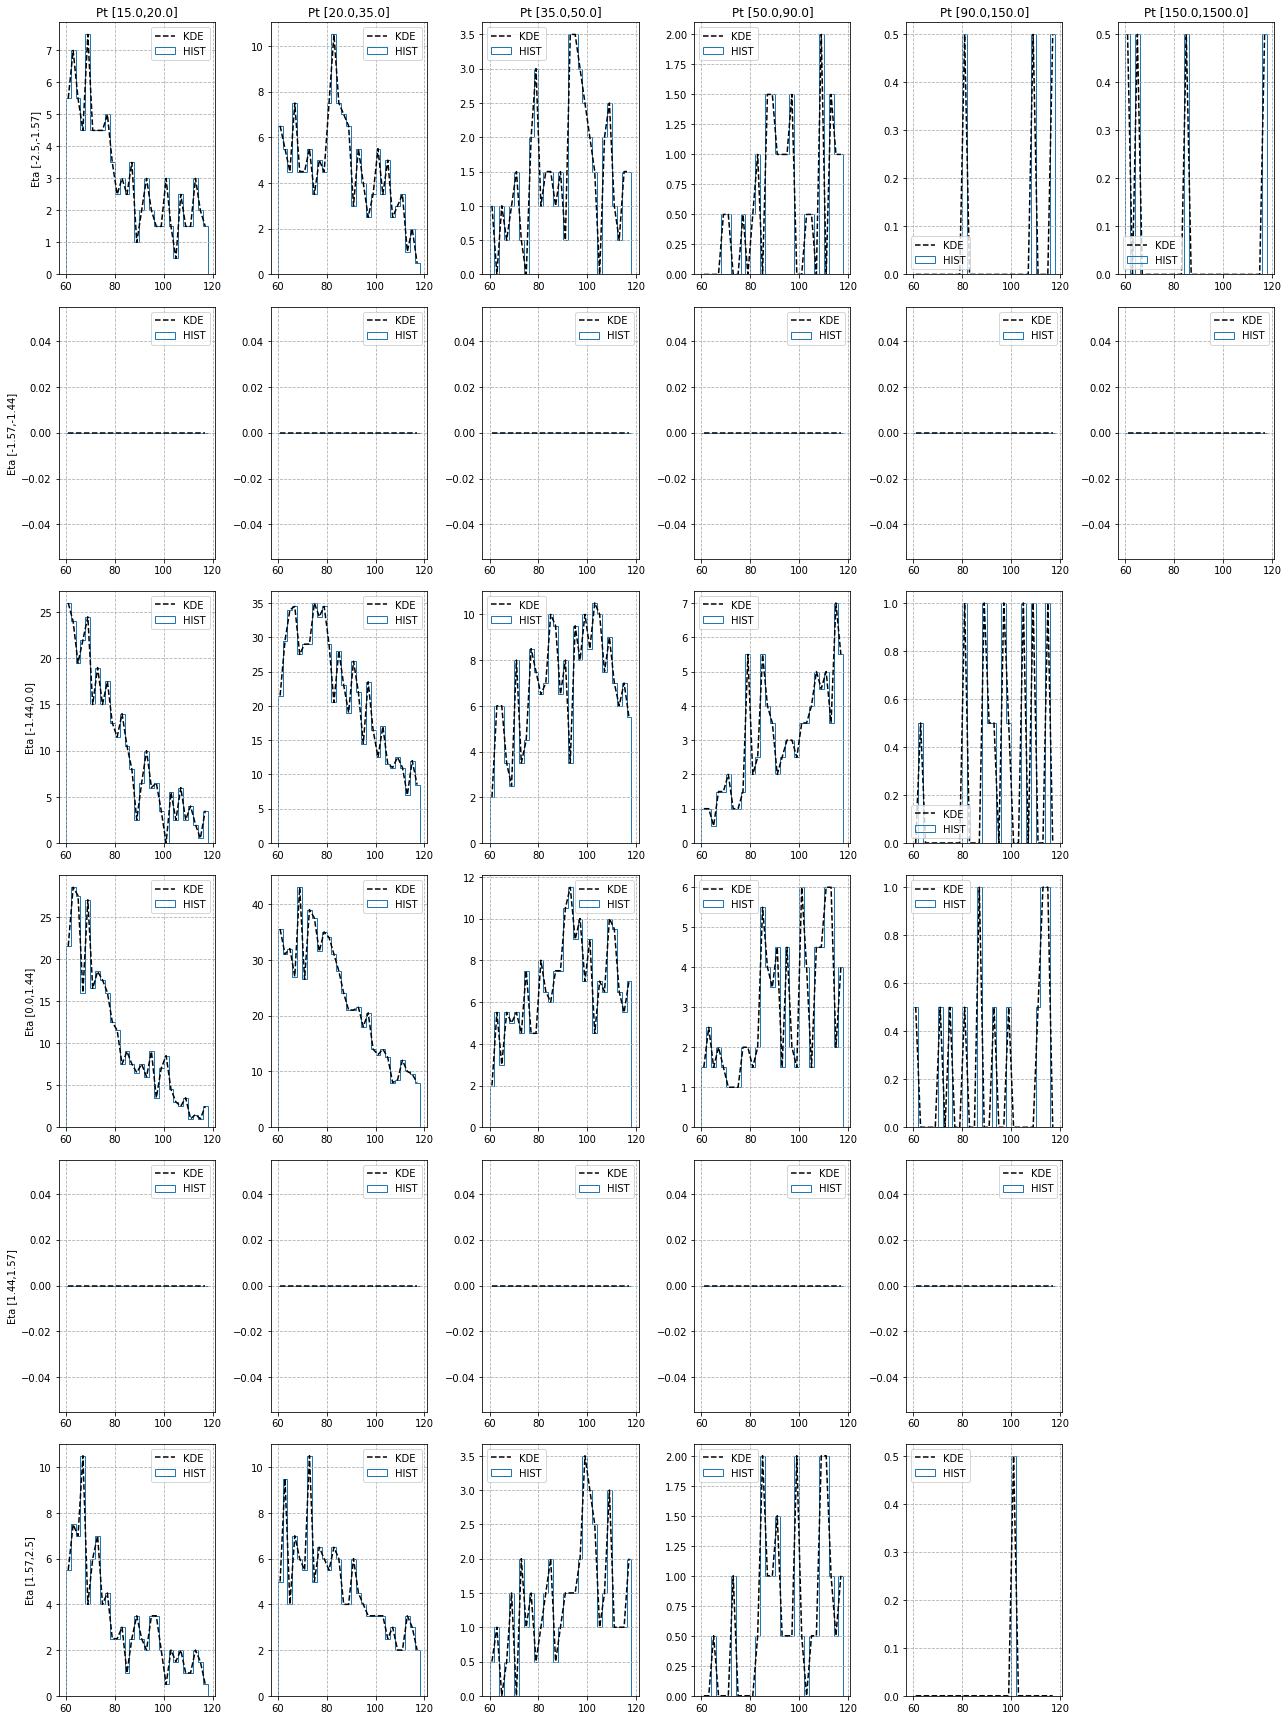

------------------------ DYJets ------------------------


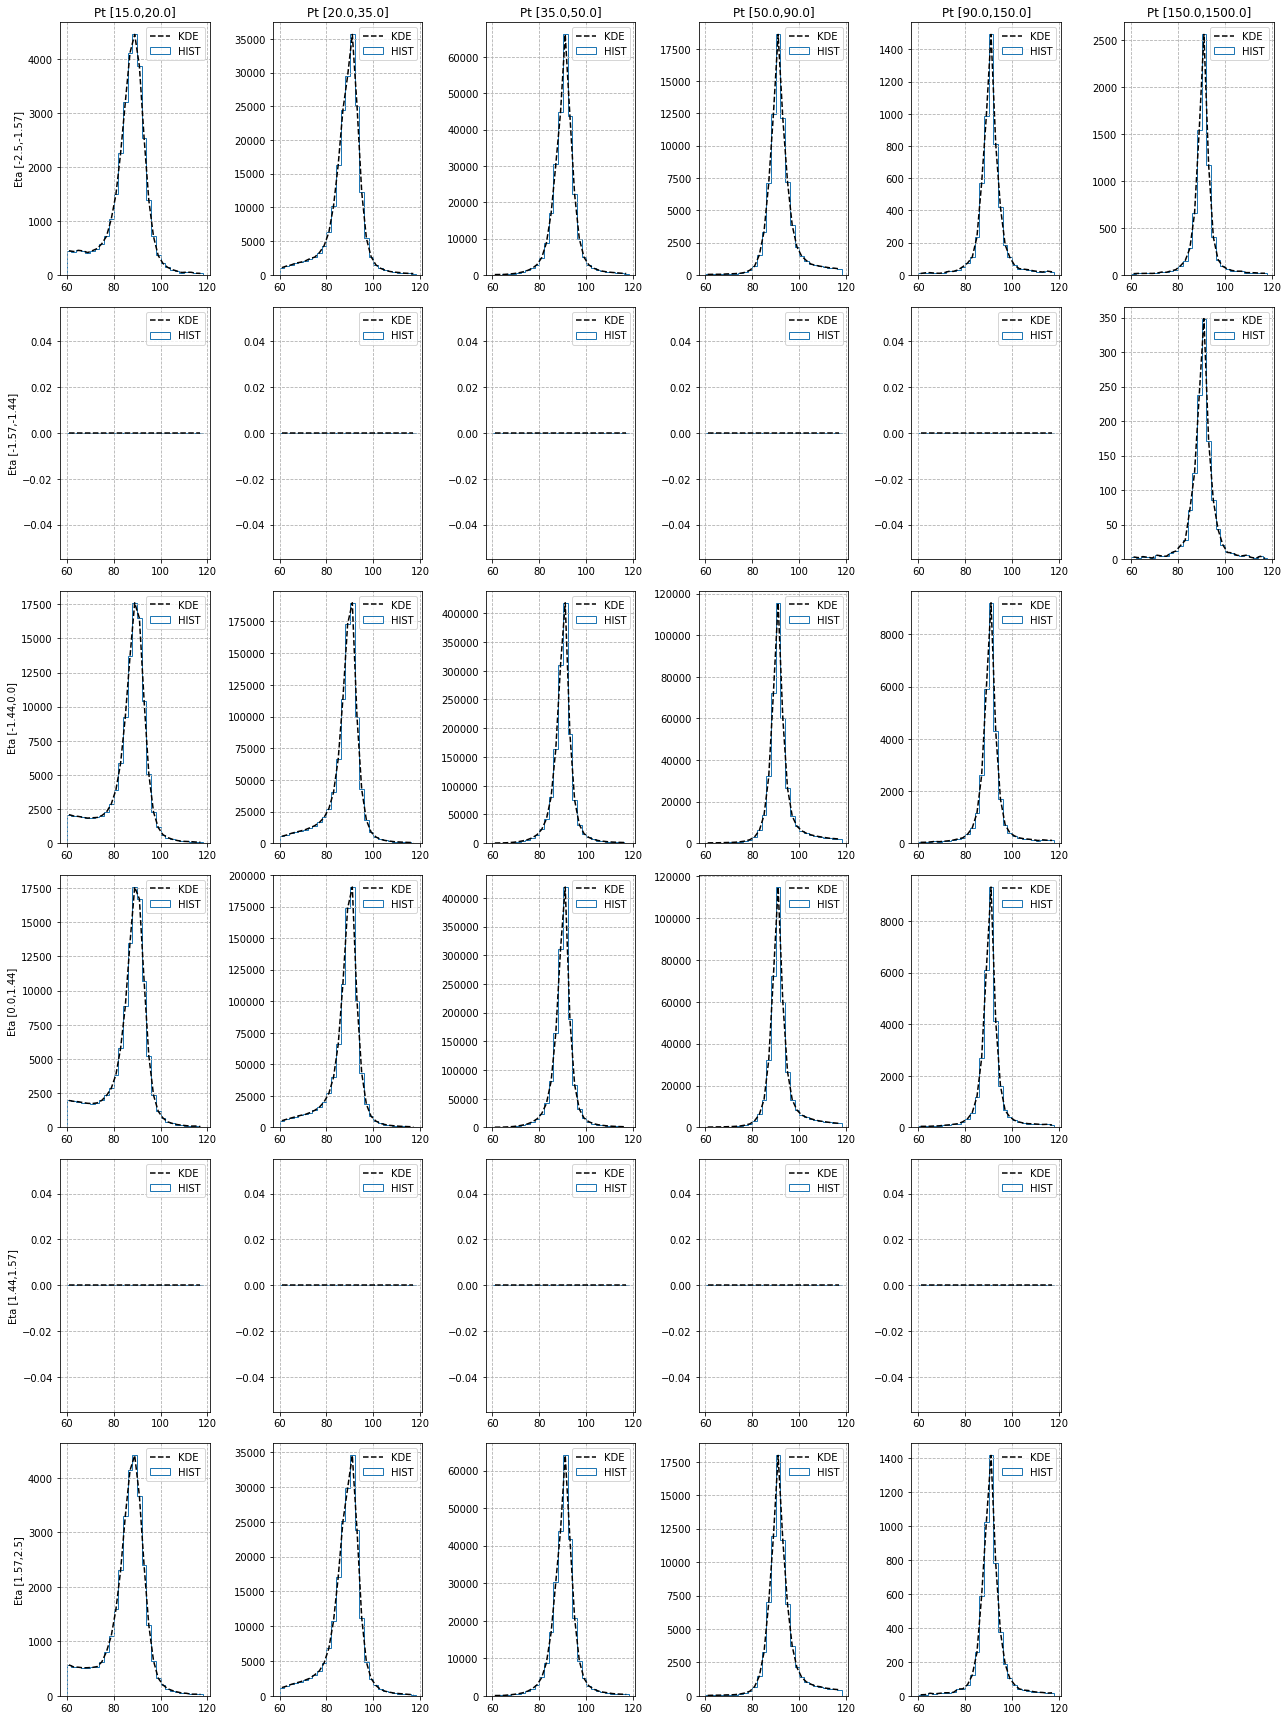

In [238]:
IDPass = False
PassFail = 'Pass'
MC[PassFail] = {}


S = 'WJets'
print('------------------------',S,'------------------------')
MC[PassFail][S] = EffGrid( 
                    sample      = dfMC[S],
                    part        = 'dilepton',
                    variable    = 'M',
                    DataMC      = 'mc',
                    samples     = S,
                    ProbeType   = 'Pass',
                    IDPass      = IDPass,
                    etaBins     = etaBins,
                    ptBins      = ptBins,
                    ranges      = ranges,
                    bins        = bins,
                    tempType    = tempType,
                    BinEBEE     = BinEBEE,
                  )


S = 'DYJets'
print('------------------------',S,'------------------------')
MC[PassFail][S] = EffGrid( 
                    sample      = dfMC[S],
                    part        = 'dilepton',
                    variable    = 'M',
                    DataMC      = 'mc',
                    samples     = S,
                    ProbeType   = 'Pass',
                    IDPass      = IDPass,
                    etaBins     = etaBins,
                    ptBins      = ptBins,
                    ranges      = ranges,
                    bins        = bins,
                    tempType    = tempType,
                    BinEBEE     = BinEBEE,
                  )



# MC Fail

------------------------ WJets ------------------------


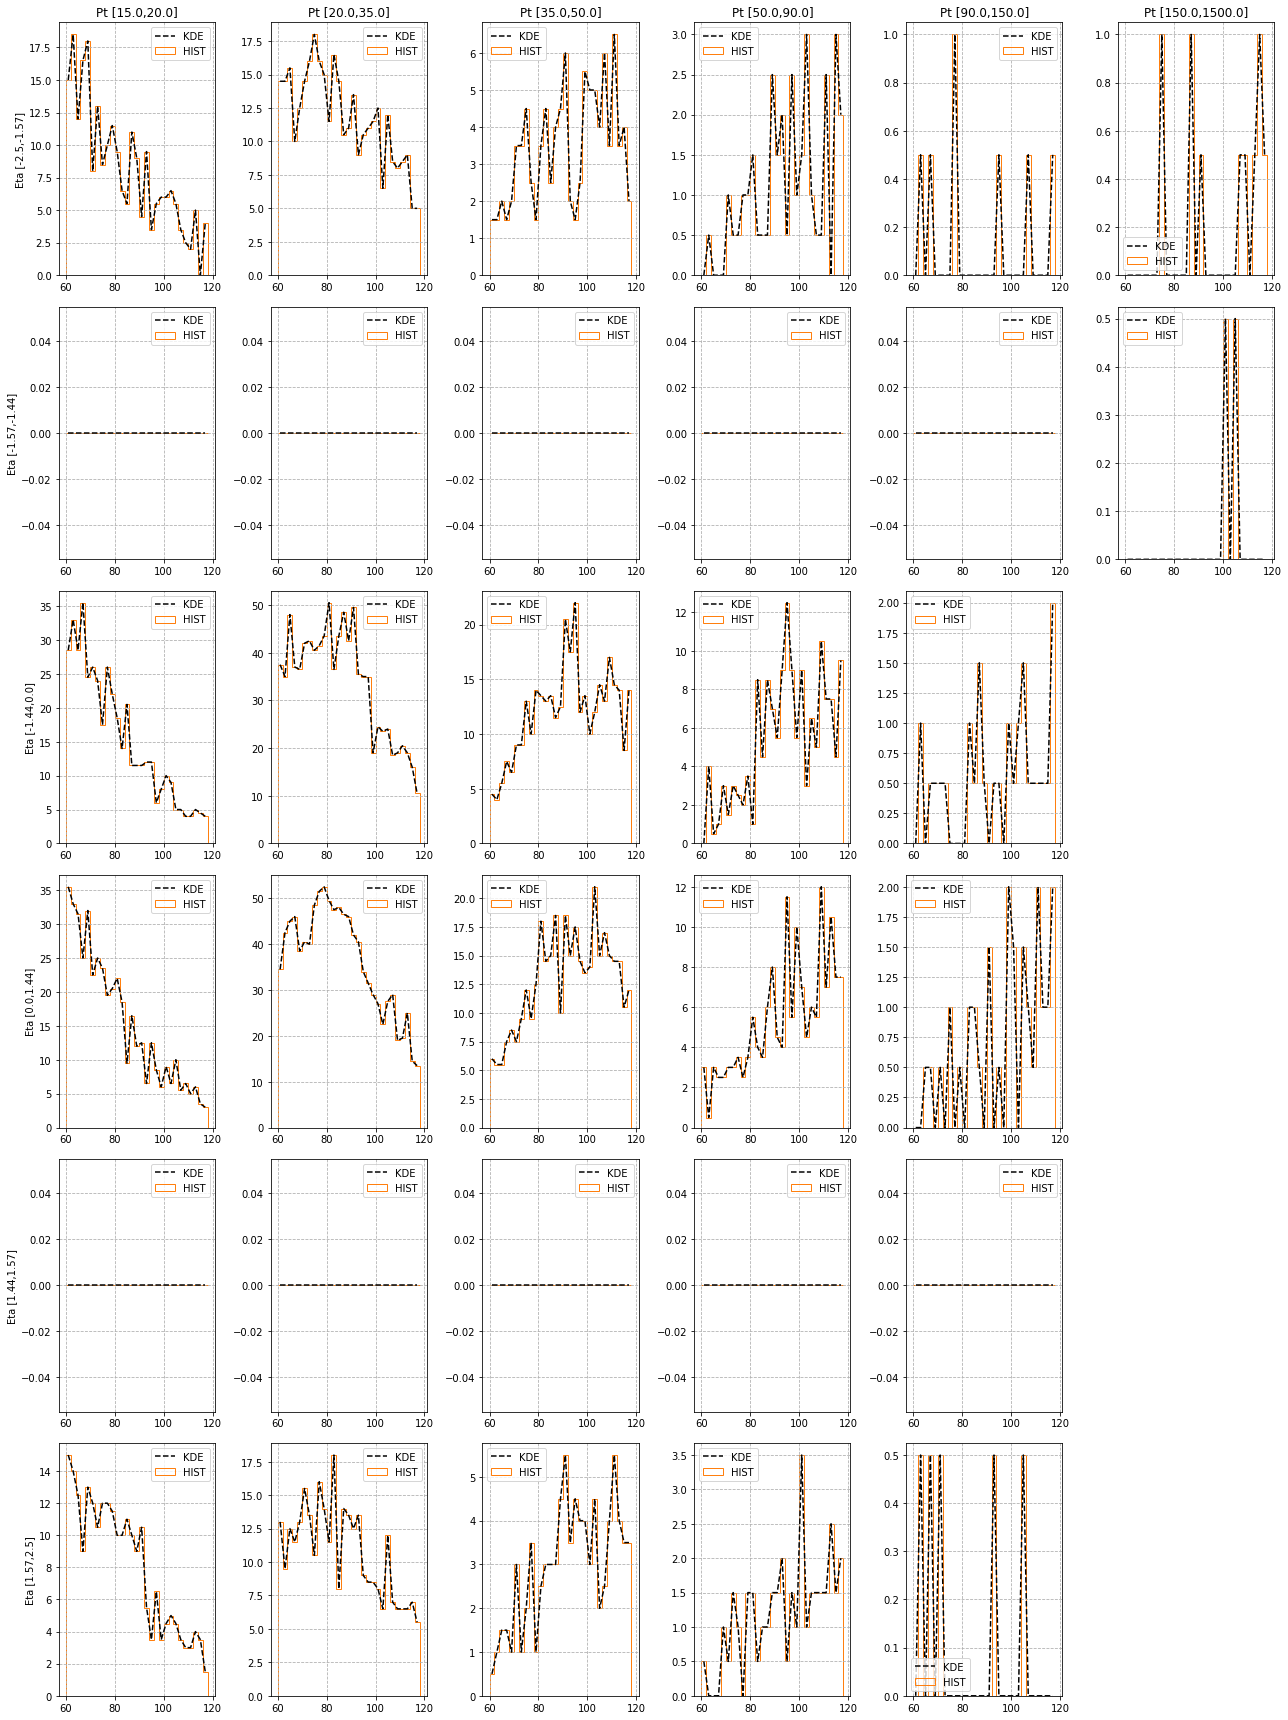

------------------------ DYJets ------------------------


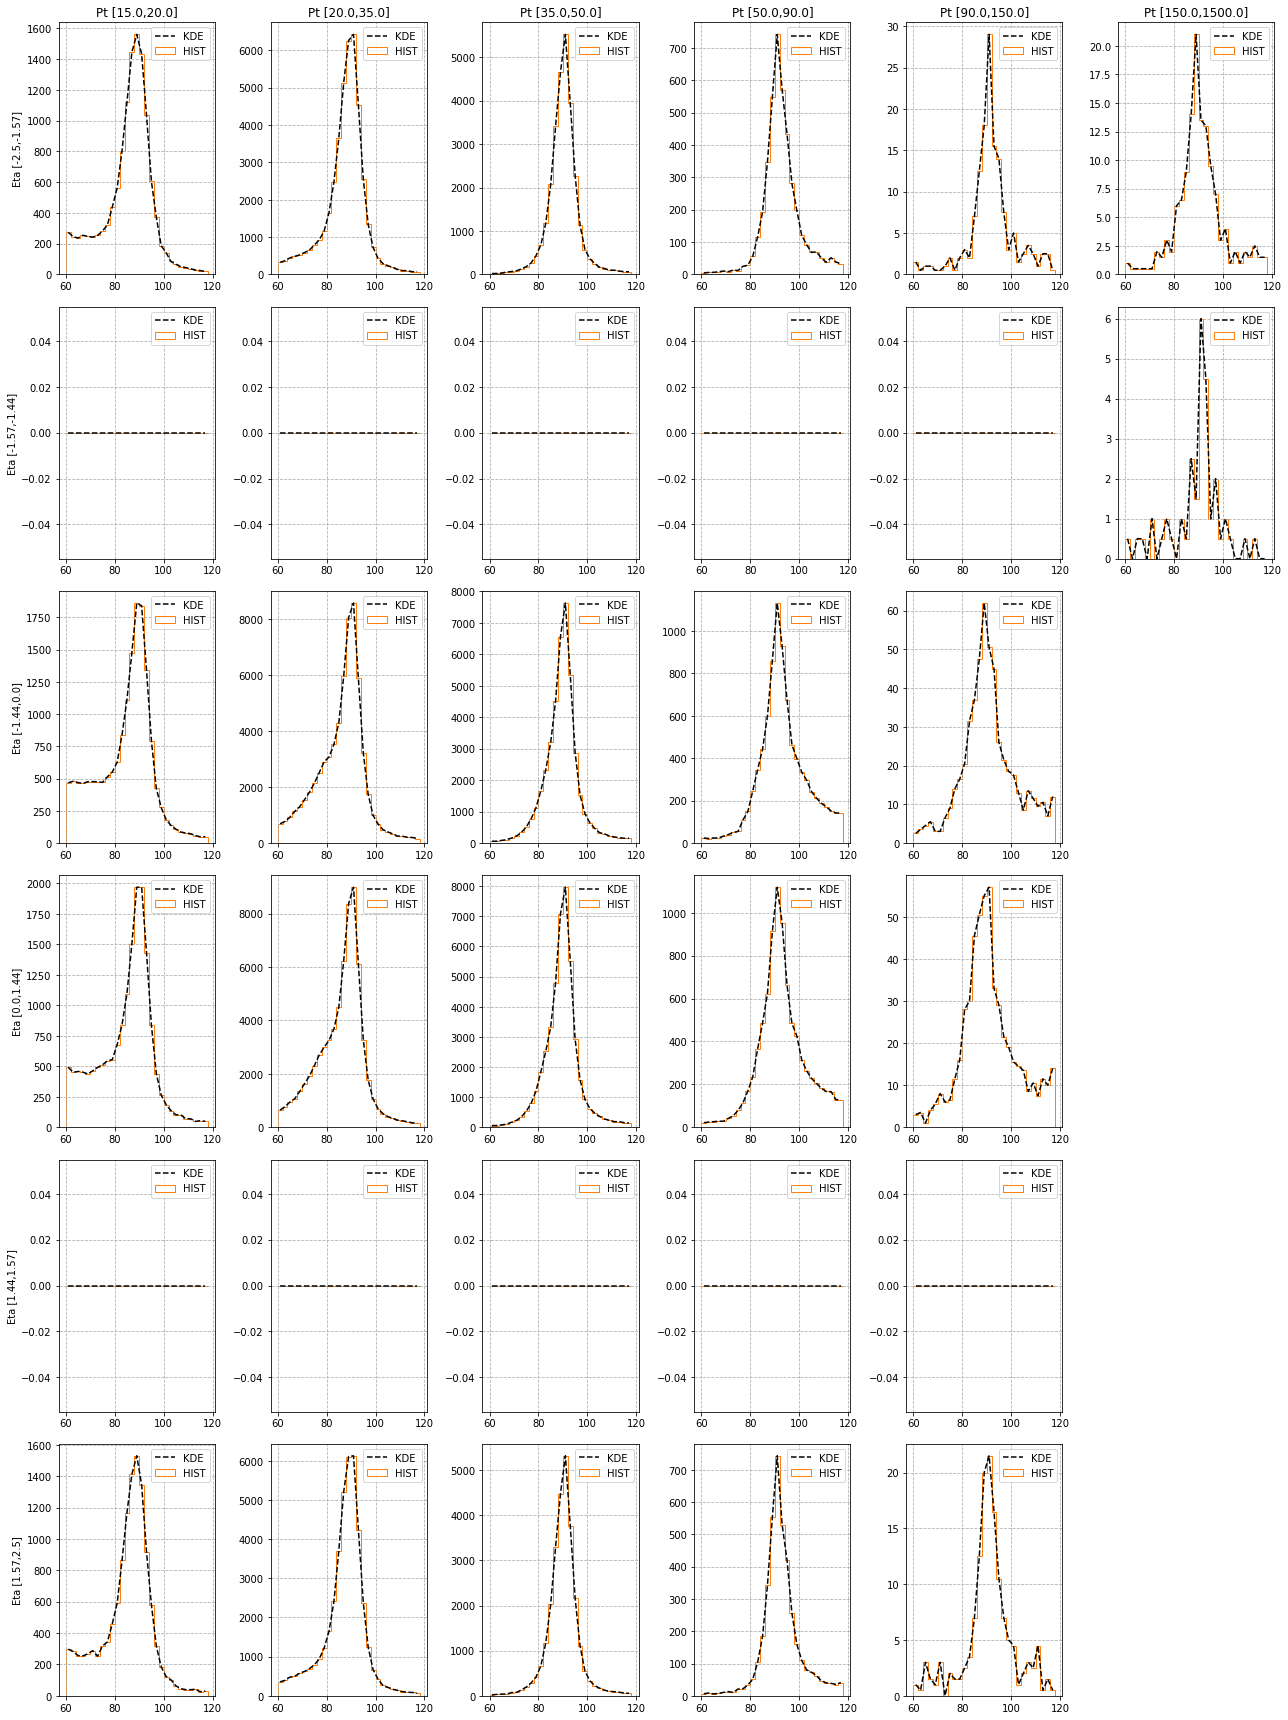

In [239]:
IDPass = False
PassFail = 'Fail'
MC[PassFail] = {}

S = 'WJets'
print('------------------------',S,'------------------------')
MC[PassFail][S] = EffGrid( 
                    sample      = dfMC[S],
                    part        = 'dilepton',
                    variable    = 'M',
                    DataMC      = 'mc',
                    samples     = S,
                    ProbeType   = 'Fail',
                    IDPass      = IDPass,
                    etaBins     = etaBins,
                    ptBins      = ptBins,
                    ranges      = ranges,
                    bins        = bins,
                    tempType    = tempType,
                    BinEBEE     = BinEBEE,
                  )

S = 'DYJets'
print('------------------------',S,'------------------------')
MC[PassFail][S] = EffGrid( 
                    sample      = dfMC[S],
                    part        = 'dilepton',
                    variable    = 'M',
                    DataMC      = 'mc',
                    samples     = S,
                    ProbeType   = 'Fail',
                    IDPass      = IDPass,
                    etaBins     = etaBins,
                    ptBins      = ptBins,
                    ranges      = ranges,
                    bins        = bins,
                    tempType    = tempType,
                    BinEBEE     = BinEBEE,
                  )

# DATA Pass

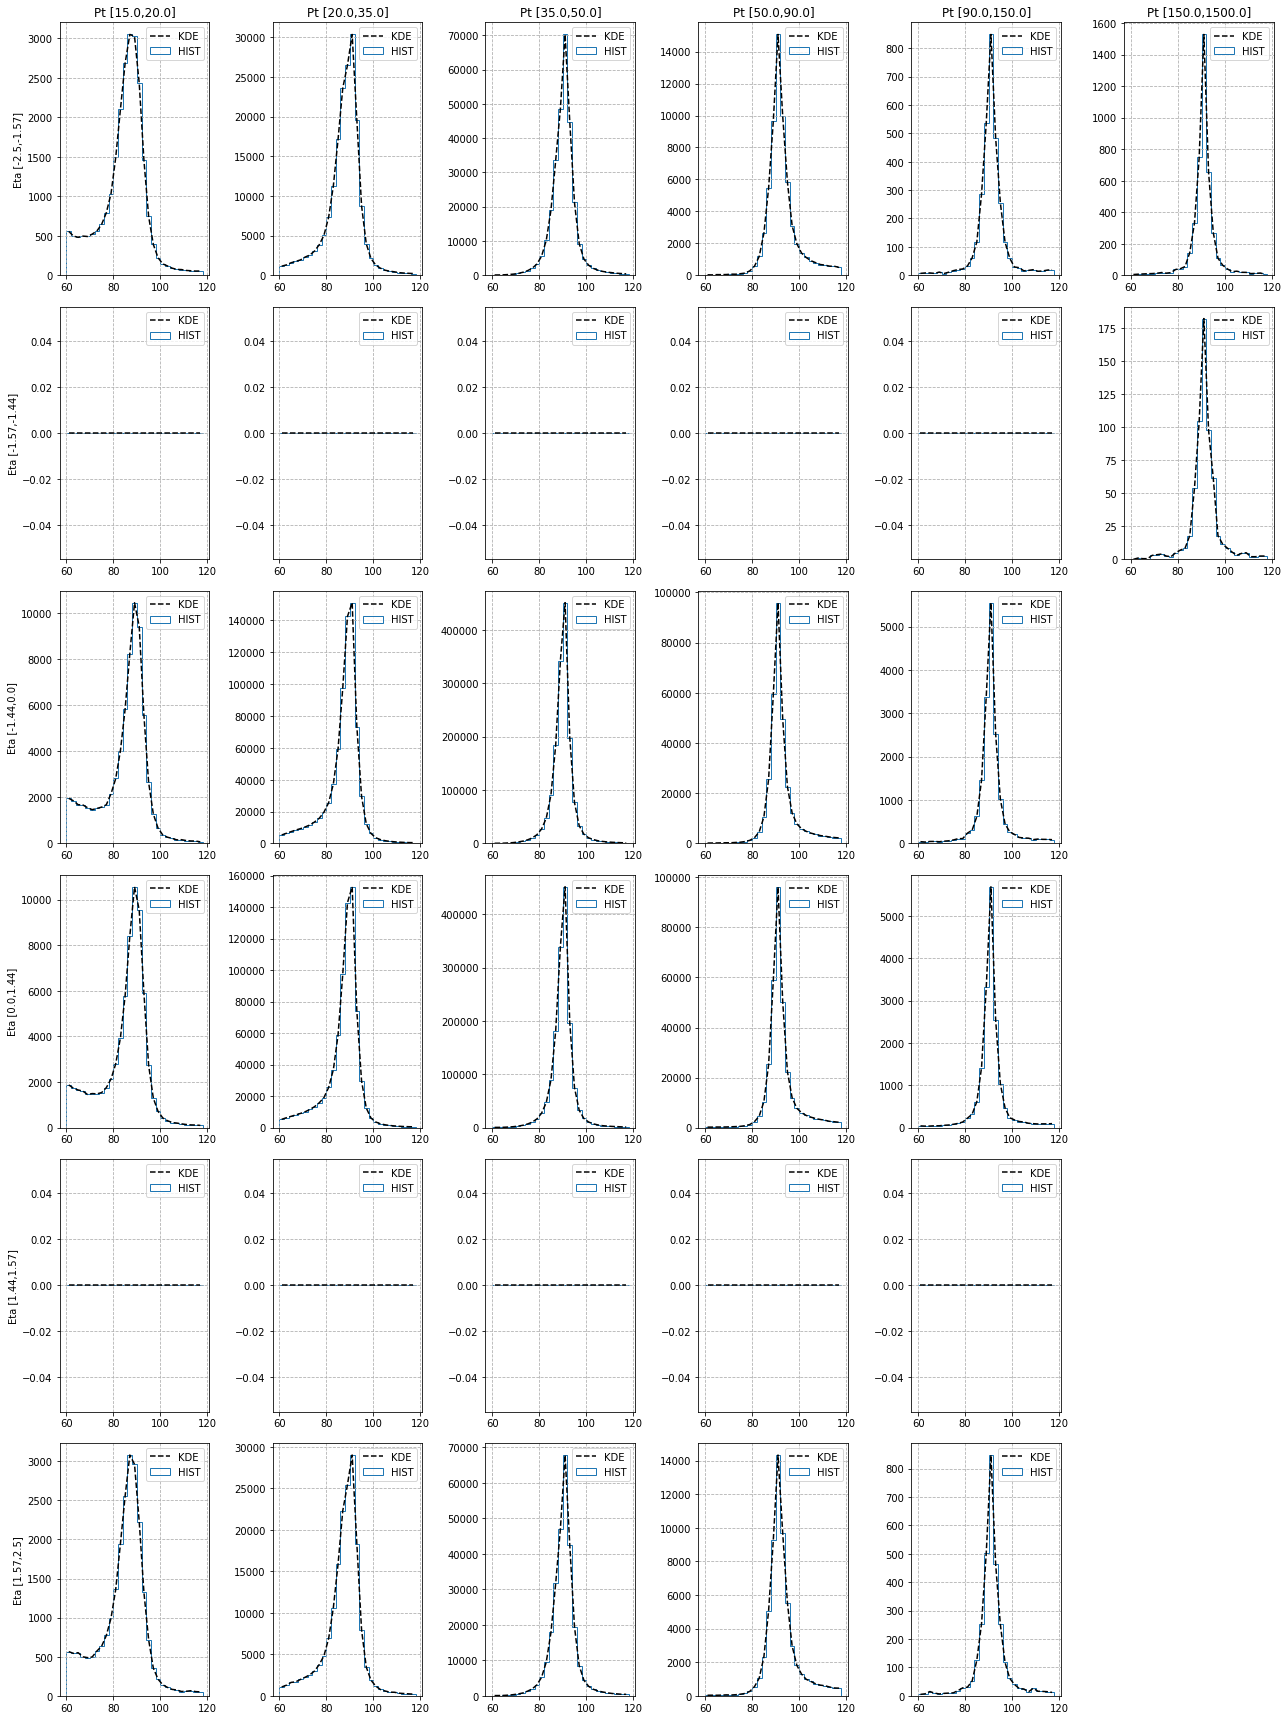

In [240]:
IDPass   = True
PassFail = 'Pass'
Data[PassFail] = EffGrid( 
                        sample       = df,
                        part         = 'dilepton',
                        variable     = 'M',
                        DataMC       = 'data',
                        samples      = '',
                        ProbeType    = 'Pass',
                        IDPass       = IDPass,
                        etaBins      = etaBins,
                        ptBins       = ptBins,
                        ranges       = ranges,
                        bins         = bins,
                        tempType     = tempType,
                        BinEBEE      = BinEBEE,
                        )

# DATA Fail

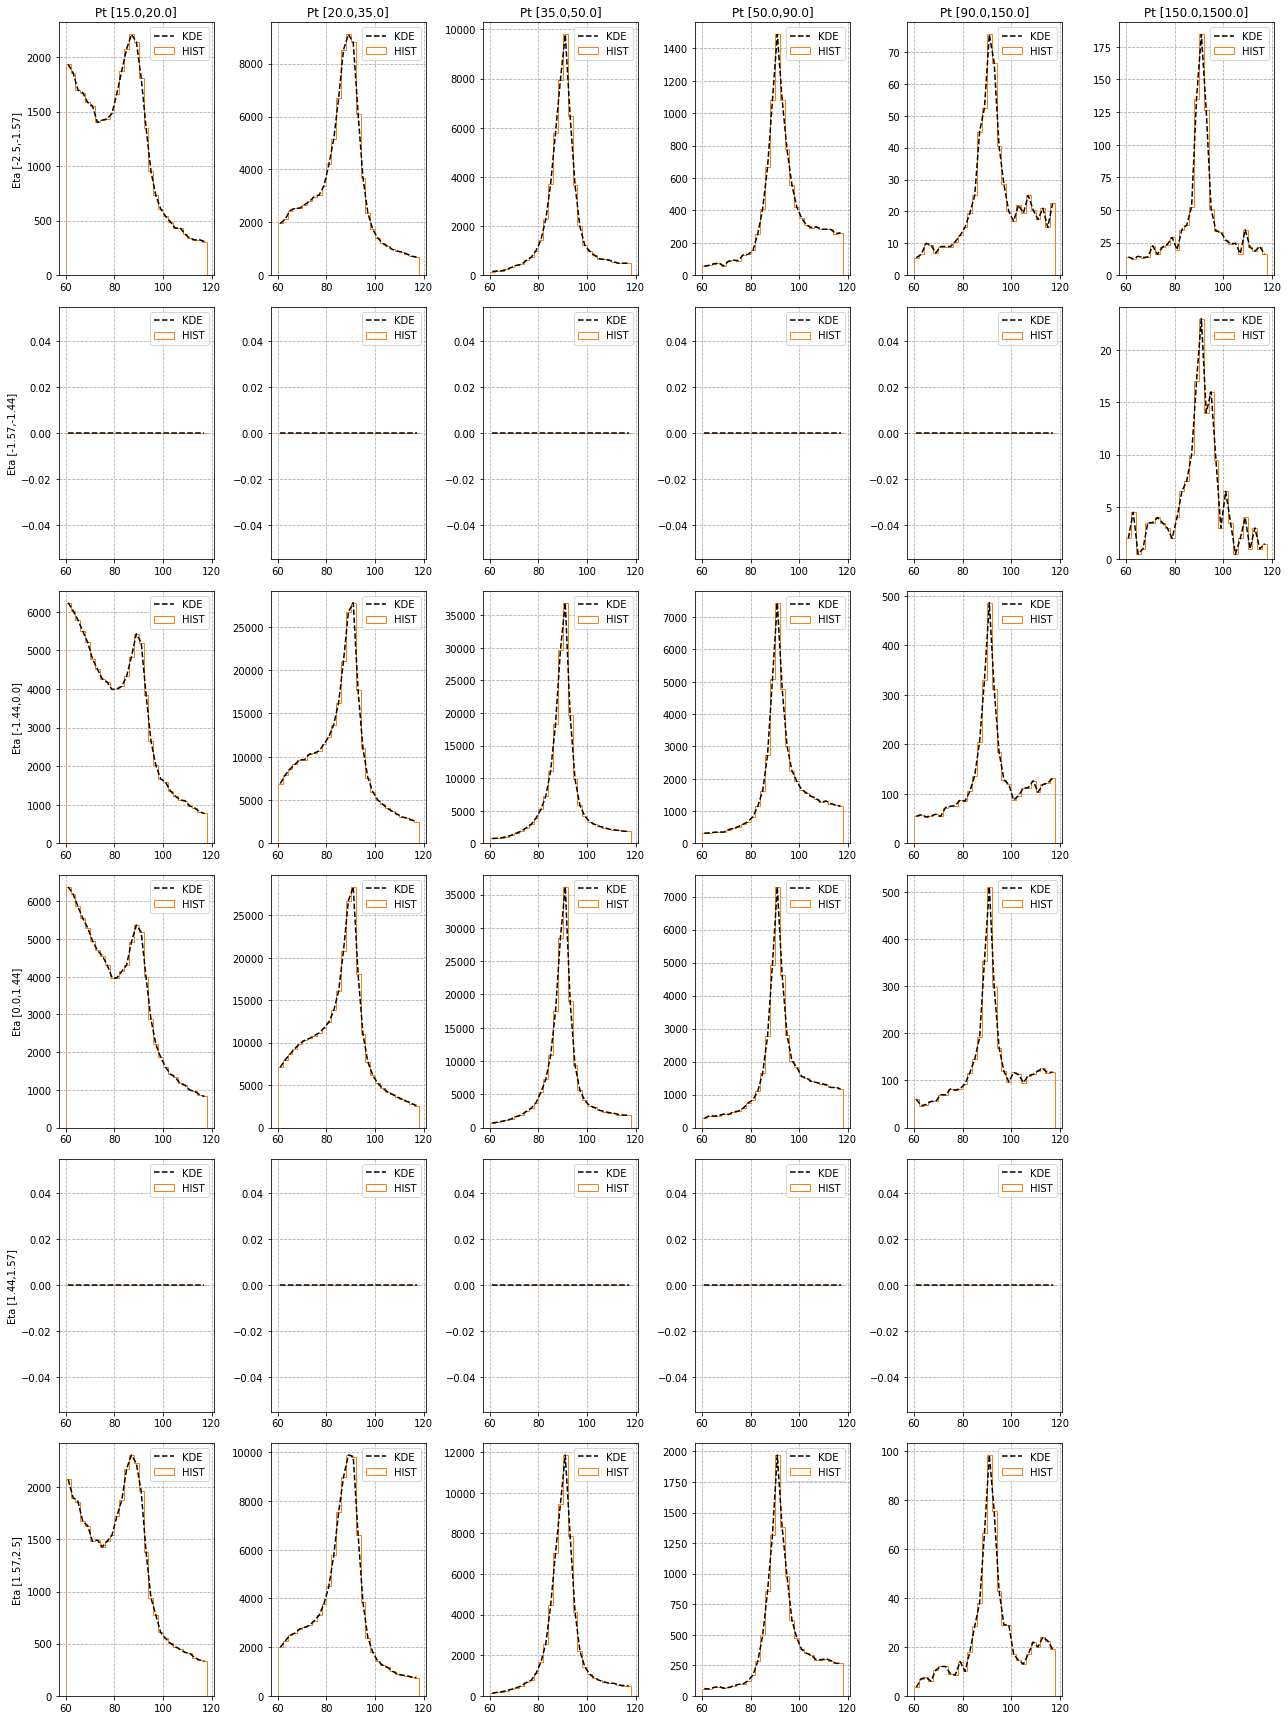

In [241]:
IDPass   = True
PassFail = 'Fail'
Data[PassFail] = EffGrid( 
                        sample      = df,
                        part        = 'dilepton',
                        variable    = 'M',
                        DataMC      = 'data',
                        samples     = '',
                        ProbeType   = 'Fail',
                        IDPass      = IDPass,
                        etaBins     = etaBins,
                        ptBins      = ptBins,
                        ranges      = ranges,
                        bins        = bins,
                        tempType    = tempType,
                        BinEBEE     = BinEBEE,    
                        )

# Fitting

In [242]:
def T(NSigPass, NBkgPass, NSigFail,NBkgFail, 
      alphaPass, betaPass, peakPass, gammaPass,
      alphaFail, betaFail, peakFail, gammaFail,
       MCPass, MCFail
     ):
    x = np.arange(0,len(MCPass))
    
    Pass = list(Template(NSigPass, NBkgPass, 
                         MCPass  , RooCMSShape(x,*(alphaPass, betaPass, peakPass, gammaPass)))) 
    
    Fail = list(Template(NSigFail, NBkgFail, 
                         MCFail, RooCMSShape(x,*(alphaFail, betaFail, peakFail, gammaFail))))
    Temp = np.array(Pass + Fail )
    return Temp

In [243]:
def TVoigt_Exp(NSigPass, NBkgPass, NSigFail,NBkgFail, 
      sigPass, GammaPass, meanPass,
      lambdaPass, xPass,
      sigFail, GammaFail, meanFail,
      lambdaFail, xFail,
       MCPass, MCFail
     ):
    x = np.arange(0,len(MCPass))
    
    argPass = lambdaPass, xPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(NSigPass, NBkgPass, 
                         Voigt(x,*argVoigtPass)  , Exp(x,*argPass))) 
    
    
    argFail = lambdaFail, xFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(NSigFail, NBkgFail, 
                         Voigt(x,*argVoigtFail) , Exp(x,*argPass)))
    
    
    Temp = np.array(Pass + Fail )
    return Temp

In [244]:
def TVoigt_CMS(NSigPass, NBkgPass, NSigFail,NBkgFail, 
      sigPass, GammaPass, meanPass,
      alphaPass, betaPass, peakPass, gammaPass,
      sigFail, GammaFail, meanFail,
      alphaFail, betaFail, peakFail, gammaFail,
       MCPass, MCFail
     ):
    x = np.arange(0,len(MCPass))
    
    argPass = alphaPass, betaPass, peakPass, gammaPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(NSigPass, NBkgPass, 
                         Voigt(x,*argVoigtPass)  , RooCMSShape(x,*argPass))) 
    
    x = np.arange(len(MCPass),len(MCPass)*2)
    argFail = alphaFail, betaFail, peakFail, gammaFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(NSigFail, NBkgFail, 
                         Voigt(x,*argVoigtFail) , RooCMSShape(x,*argFail)))
    
    
    Temp = np.array(Pass + Fail )
    return Temp

In [245]:
def PlotFitting(ax,
                NSig ,NBkg,
                DATA, SIG, BKG,
                eta, pt,
                color,
               ):
    TemplatePlot    = Template(NSig,NBkg, SIG, BKG)
    TemplatePlotBkg = NBkg*BKG/np.sum(BKG)
    DataPlot        = DATA
    #DataPlot        = Data[PassFail][0][IJ]/Data[PassFail][1][IJ] 

        
    ax.plot(xc,    TemplatePlot, color = color[0], linestyle='--', label=    'Fit')
    ax.plot(xc, TemplatePlotBkg, color = color[1], linestyle='--', label='Fit Bkg')
    ax.plot(xc,        DataPlot, color = color[2], linestyle= '-', label=   'Data')

    ax.legend()
    ax.grid(linestyle='--')

    if j == 0:
        ax.set_ylabel('Eta ['+str(round(eta[0],2))+','+str(round(eta[1],2))+']'  )        
    if i == 0:
        ax.set_title('Pt ['+str(pt[0])+','+str(pt[1])+']' )

In [246]:
def Fit(i,j,
        MC_PASS_S, MC_PASS_B,
        MC_FAIL_S, MC_FAIL_B,
        DATA_PASS, DATA_FAIL,
        p0, Bounded,
        Type   = '',
        Print  = False,
        TryMax = 20,
        ):
    if Type == 'Exp':
        Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail,      \
                        alphaPass, betaPass, peakPass, gammaPass,   \
                        alphaFail, betaFail, peakFail, gammaFail:   \
                        T(NSigPass, NBkgPass, NSigFail,NBkgFail,    \
                          alphaPass, betaPass, peakPass, gammaPass, \
                          alphaFail, betaFail, peakFail, gammaFail, \
                          MCPass = MC_PASS_S, MCFail = MC_FAIL_S)        
    elif Type == 'Voigt_CMS':
        Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail, \
                        sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                        sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail: \
                        TVoigt_CMS(NSigPass, NBkgPass, NSigFail,NBkgFail, \
                                   sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                                   sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail, \
                                   MCPass = MC_PASS_S, MCFail = MC_FAIL_S)        
    elif Type == 'Voigt_Exp':
        Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail, \
                        sigPass, GammaPass, meanPass, lambdaPass, xPass, \
                        sigFail, GammaFail, meanFail, lambdaFail, xFail: \
                        TVoigt_Exp(NSigPass, NBkgPass, NSigFail,NBkgFail, \
                                    sigPass, GammaPass, meanPass, lambdaPass, xPass, \
                                    sigFail, GammaFail, meanFail, lambdaFail, xFail, \
                                    MCPass = MC_PASS_S, MCFail = MC_FAIL_S)     
    else:
        Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail: \
                        np.array(list(Template(NSigPass, NBkgPass, MC_PASS_S, MC_PASS_B)) +  \
                                 list(Template(NSigFail, NBkgFail,MC_FAIL_S, MC_FAIL_B)))
        
    ###############################
    
    DATA = np.array(list(DATA_PASS) + list(DATA_FAIL))

    model  = lambda x0:CHI2(DATA=DATA,Temp=Temp,*x0)

    fitSucess = False
    tries = 0
    
    while not fitSucess:
        if Print:
            print('--- Start Fitting')
        fitResult = minimize(model,
                             p0,
                             method = 'L-BFGS-B',
                             bounds = Bounded
                            )
        fitSucess = fitResult.success
        FIT = fitResult.x

        p0 = GoodGuess(i,j,len(etaBINS),len(ptBins),tries,p0)
        if not p0:
            p0 = np.ones(len(Bounded))
            break;
        tries += 1
        
        if tries%10 == 0 and Print:
            print('Try: ' + str(tries))
        if tries > TryMax and Print :
            print("Maximum tries reached!")
            break
    return FIT

/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Reach Maximum tries


/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Reach Maximum tries
Reach Maximum tries
Reach Maximum tries
Reach Maximum tries
Reach Maximum tries
Reach Maximum tries
Reach Maximum tries
Reach Maximum tries
Reach Maximum tries


/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/jcordero/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


Reach Maximum tries
Reach Maximum tries


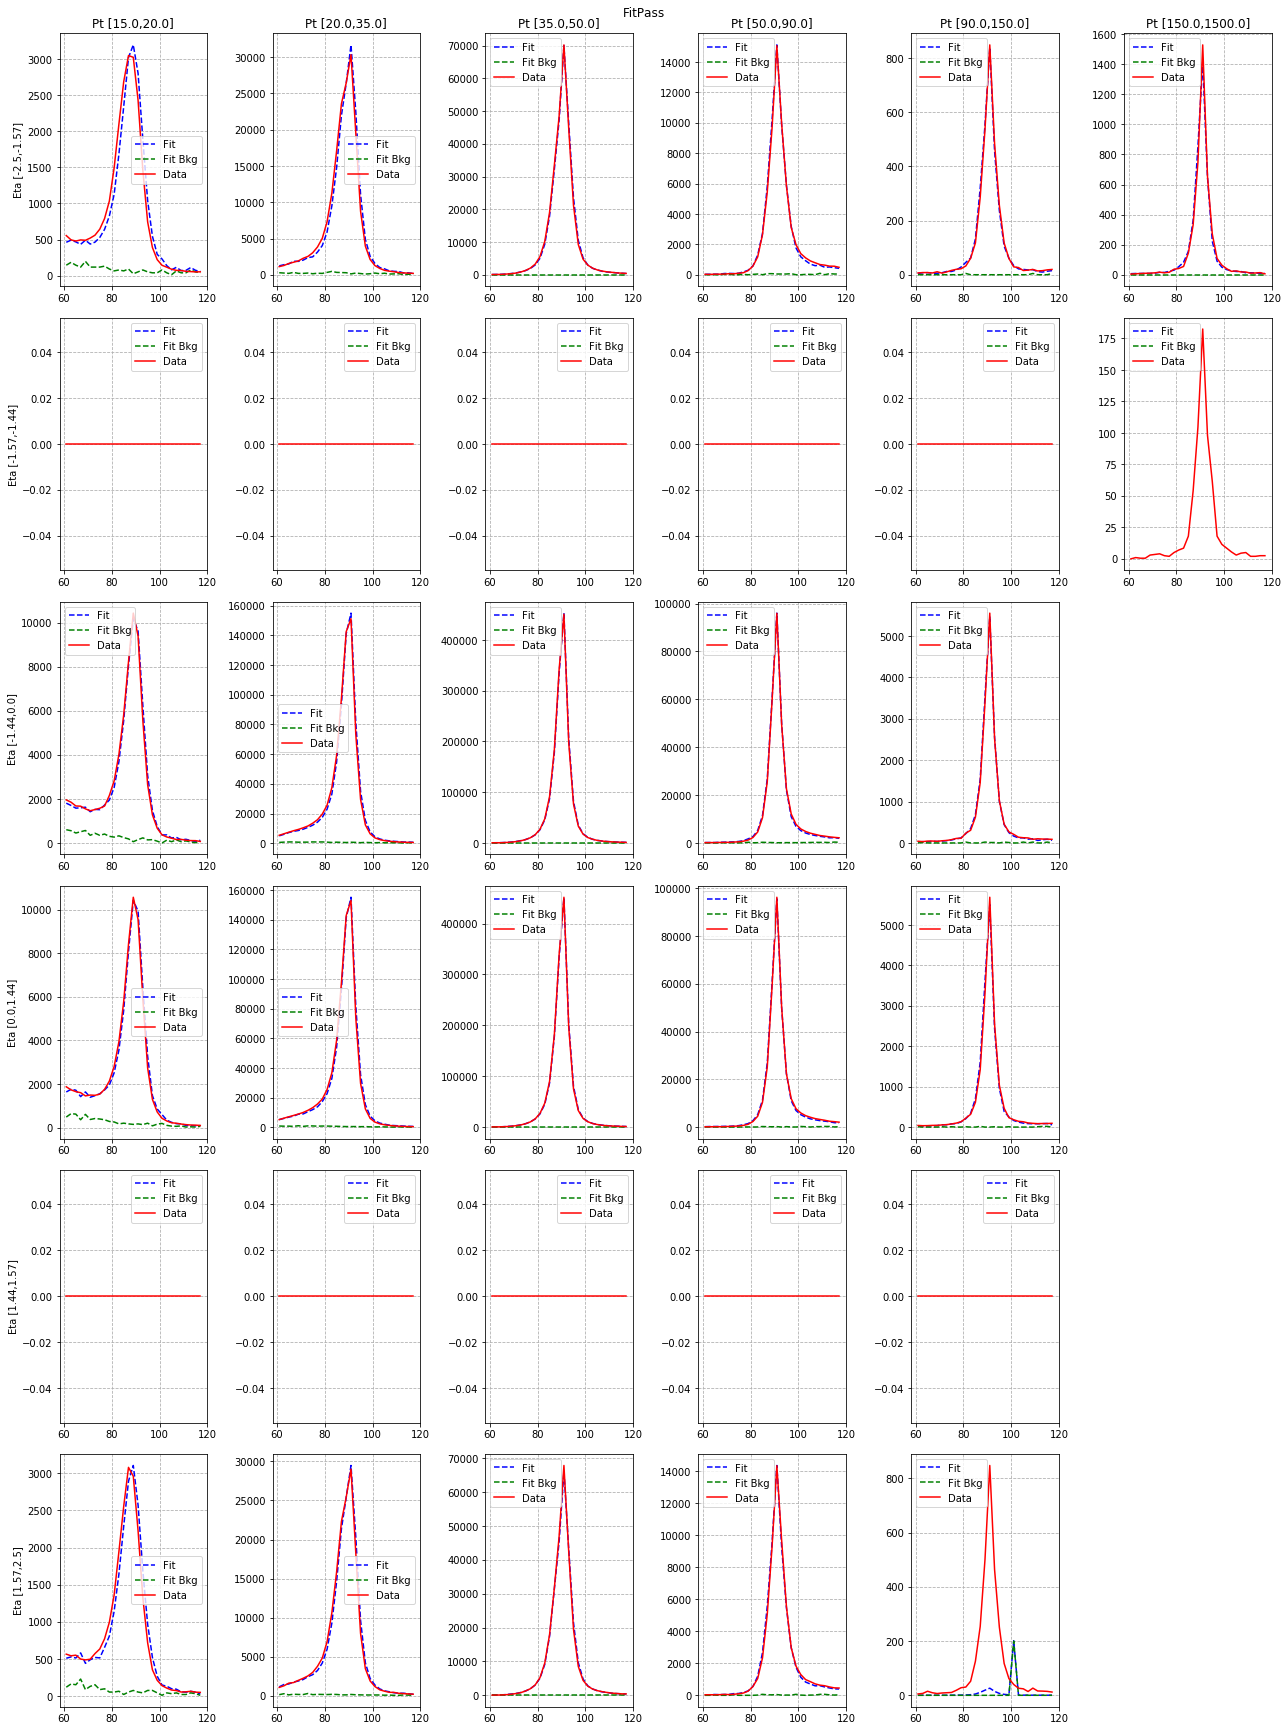

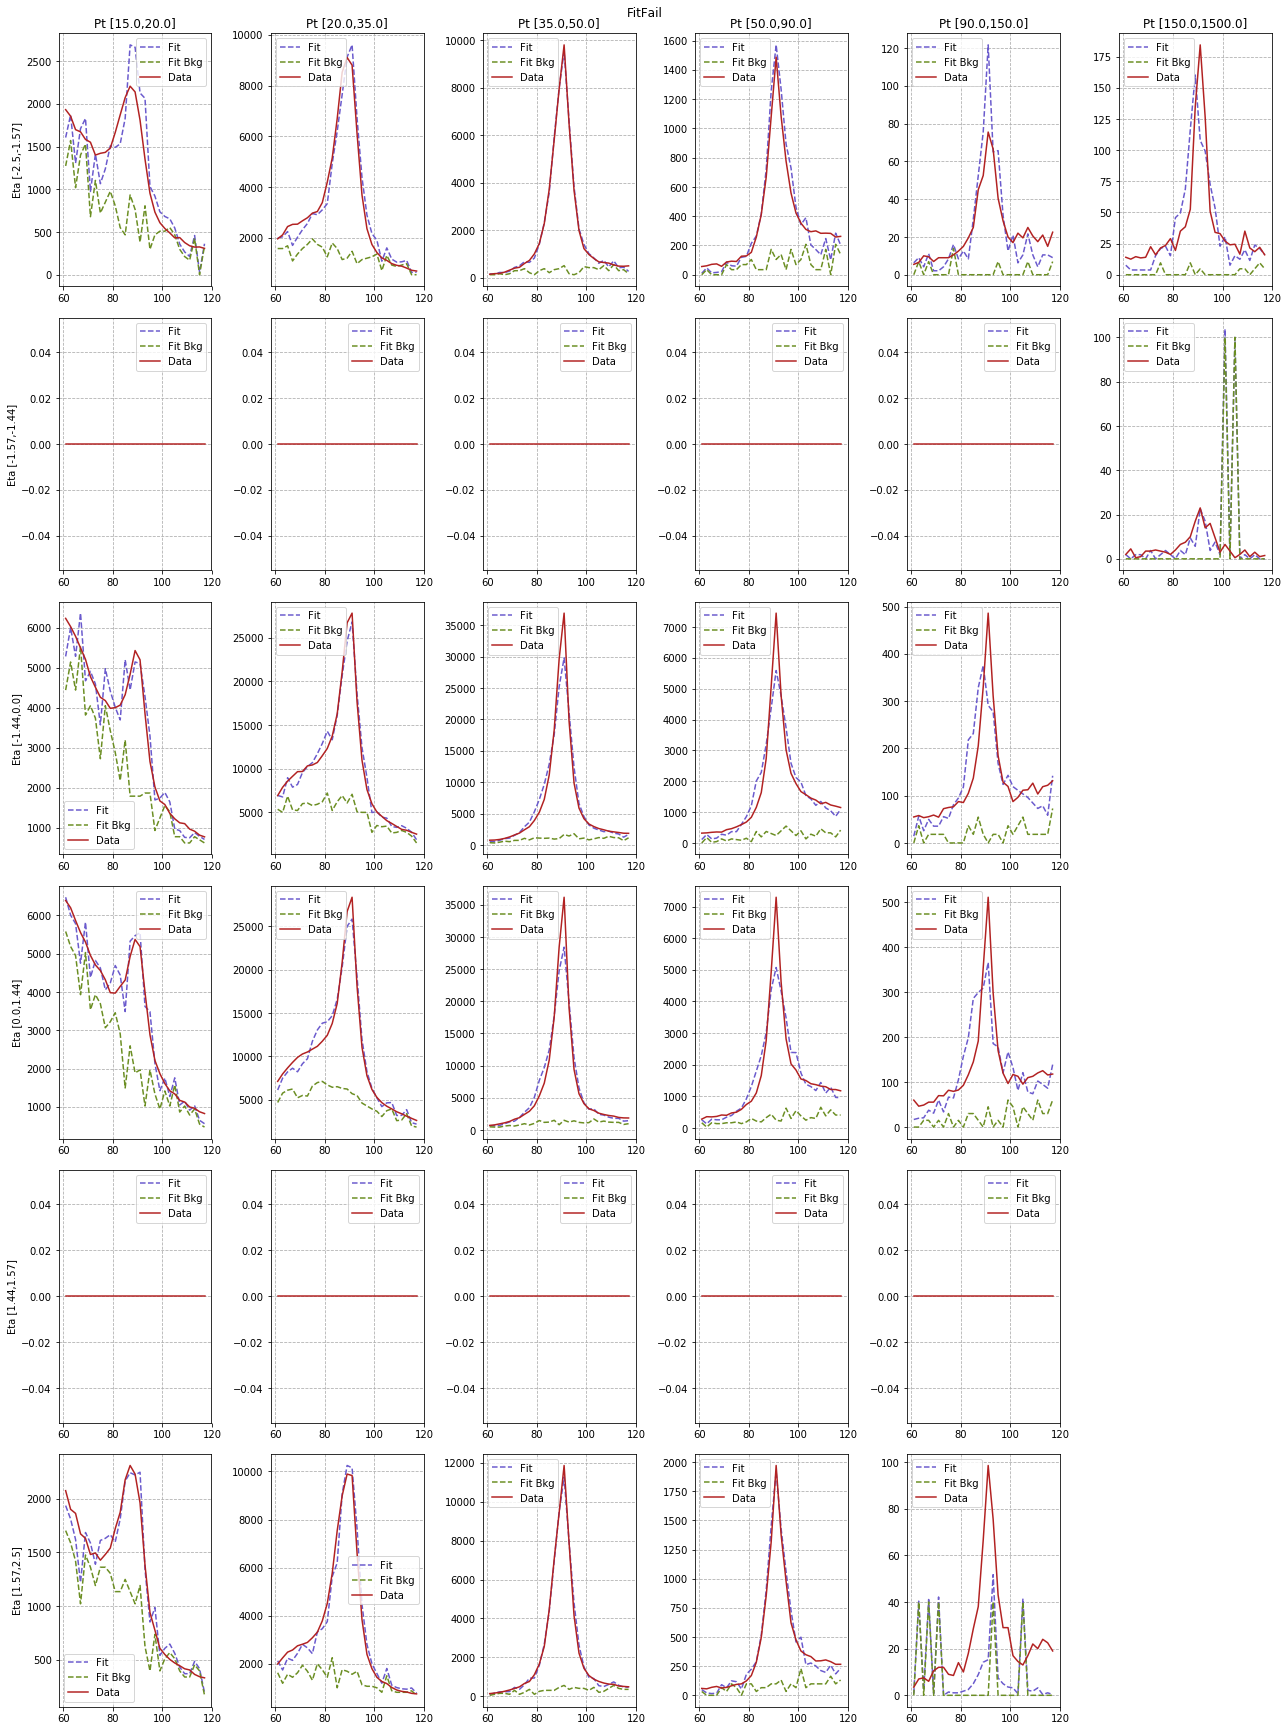

In [247]:
p0 = [1,1,1,1]
Bounded = ((0,np.inf),
           (0,np.inf),
           (0,np.inf),
           (0,np.inf))

###################################      
    
etaBinsEBEE    = [[0,1.4442],[1.566,2.5]]
etaBins,ptBins = BinFormat(etaBins), BinFormat(ptBins)
etaNBin,ptNBin = len(etaBins),len(ptBins)

eff = {}

fit = []
figx, figy = etaNBin, ptNBin

fig  = plt.figure(1,figsize=(figy*3,figx*4))
fig1 = plt.figure(2,figsize=(figy*3,figx*4))

for j in np.arange(ptNBin):
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
    eff[j] = {}
    for i in np.arange(len(etaBINS)):
        ij = ptNBin*i + (j+1)     
        IJ = i + (j*etaNBin)

        FIT = Fit(  i,j,
                    MC['Pass']['DYJets'][0][j][i], MC['Pass']['WJets'][0][j][i],
                    MC['Fail']['DYJets'][0][j][i], MC['Fail']['WJets'][0][j][i],
                    Data['Pass'][0][j][i]        , Data['Fail'][0][j][i],
                    p0, Bounded,
                    Type = '',
                    Print  = False,
                    TryMax = 100,
                    )
        #print(j,i,FIT)
        ######################################################################################
        PassFail = 'Pass'
        
        plt.figure(1)
        ax = plt.subplot(len(etaBins),len(ptBins),ij)
        color = ['b','g','r']

        PlotFitting(
                    ax,
                    NSig  = FIT[0], NBkg = FIT[1],
                    DATA  = Data[PassFail][0][j][i],
                    SIG   = MC[PassFail]['DYJets'][0][j][i],
                    BKG   = MC[PassFail]['WJets'][0][j][i],
                    eta   = etaBINS[i], pt = ptBins[j],
                    color = color,
                   )
        
        eff[j][i] = FIT[0]/(FIT[0]+FIT[2])
        if np.isnan(eff[j][i]):
            eff[j][i] = 0.0
        ######################################################################################    
        PassFail = 'Fail'
        
        plt.figure(2)
        ax1 = plt.subplot(len(etaBins),len(ptBins),ij)
        color = ['slateblue','olivedrab','firebrick']

        PlotFitting(
                    ax1,
                    NSig  = FIT[2], NBkg = FIT[3],
                    DATA  = Data[PassFail][0][j][i],
                    SIG   = MC[PassFail]['DYJets'][0][j][i],
                    BKG   = MC[PassFail]['WJets'][0][j][i],
                    eta   = etaBINS[i], pt = ptBins[j],
                    color = color,
                   )
        ######################################################################################

fig.tight_layout()        
fig1.tight_layout()        

     
fig.suptitle("FitPass",y=1)
fig1.suptitle("FitFail",y=1) 

fig .savefig(figpath+"FitPass.png")        
fig1.savefig(figpath+"FitFail.png")     
plt.show()



# Saving root file

In [248]:
path = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Efficiency/zee/"
fileOut = TFile(path+"eff_photon_data.root","recreate")
tree = TTree("eff_photon","eff_photon")

ptBins, etaBins = BinFormat(ptBins,Type = 'edges'),BinFormat(etaBins,Type = 'edges')
ptNBins, etaNBins = len(ptBins)-1 , len(etaBins)-1

hist2d = TH2F("EGamma_eff","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)

etaBins = BinFormat(etaBins)
tree.Branch("eff",hist2d,"TH2F")
for j in range(ptNBins):
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins

    if len(etaBINS) > 2:
        for i in np.arange(len(etaBINS)):
            hist2d.SetBinContent(int(j)+1, int(i)+1, eff[j][i])
            tree.Fill()
    else:
        for i in range(len(etaBins)):
            if np.abs(np.average(etaBins[i])) > 1.566:
                EFF = eff[j][0]
            elif np.abs(np.average(etaBins[i])) < 1.4442:
                EFF = eff[j][1]
                I = 2
            else:
                EFF = 0
            #print(j,i,I,eff[j][I])
            hist2d.SetBinContent(int(j)+1, int(i)+1, EFF)
            tree.Fill()
fileOut.Write()
fileOut.Close()

# Fitting with RooCMSShape

In [249]:
########## TEMPLATES ################
def TVoigt_Test(
                  NSigPass,NBkgPass, NSigFail,NBkgFail, 
                  sigPass, GammaPass, meanPass,
                  lambdaPass, xPass,
                  sigFail, GammaFail, meanFail,
                  lambdaFail, xFail,
                  MCPass, MCFail
                 ):
    
    x = np.arange(0,len(MCPass))
    
    argPass = lambdaPass, xPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(NSigPass, NBkgPass, Voigt(x,*argVoigtPass)  , Exp(x,*argPass))) 
    
    
    argFail = lambdaFail, xFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(NSigFail, NBkgFail, 
                         Voigt(x,*argVoigtFail) , Exp(x,*argPass)))
    
    
    #Temp = np.array(Pass + Fail )
    Temp = np.array(Pass)
    return Temp

def TVoigt_noSig(
                  NBkgPass,NBkgFail, 
                  sigPass, GammaPass, meanPass,
                  lambdaPass, xPass,
                  sigFail, GammaFail, meanFail,
                  lambdaFail, xFail,
                  MCPass, MCFail
                 ):
    x = np.arange(0,len(MCPass))
    
    argPass = lambdaPass, xPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(0, NBkgPass, Voigt(x,*argVoigtPass)  , Exp(x,*argPass))) 
    
    
    argFail = lambdaFail, xFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(0, NBkgFail, 
                         Voigt(x,*argVoigtFail) , Exp(x,*argPass)))
    
    
    #Temp = np.array(Pass + Fail )
    Temp = np.array(Pass)
    return Temp

def TVoigt_CMS(NSigPass, NBkgPass, NSigFail,NBkgFail, 
              sigPass, GammaPass, meanPass,
              alphaPass, betaPass, peakPass, gammaPass,
              sigFail, GammaFail, meanFail,
              alphaFail, betaFail, peakFail, gammaFail,
               MCPass, MCFail
             ):
    x = np.arange(0,len(MCPass))
    
    argPass      = alphaPass, betaPass, peakPass, gammaPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(NSigPass, NBkgPass, 
                         Voigt(x,*argVoigtPass)  , RooCMSShape(x,*argPass))) 
    
    
    x = np.arange(len(MCPass),len(MCPass)*2)
    argFail      = alphaFail, betaFail, peakFail, gammaFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(NSigFail, NBkgFail, 
                         Voigt(x,*argVoigtFail) , RooCMSShape(x,*argFail)))
    
    
    Temp = np.array(Pass + Fail )
    return Temp

def Voigt_CMS(
                xc,
                NSig, NBkg, 
                sig, Gamma, mean,
                alpha, beta, peak, gamma,
                ):
    x = xc
    arg      = alpha, beta, peak, gamma
    argVoigt = sig, Gamma, mean
    Temp = list(Template(NSig, NBkg, 
                         Voigt(x,*argVoigt) , RooCMSShape(x,*arg)))
    
    
    return np.array(Temp)

def Template(Nsig,Nbkg,Sig,Bkg):
    return Nsig * (Sig/np.sum(Sig)) + Nbkg * (Bkg/np.sum(Bkg))

########## METRIC ########
def NLL(DATA,Temp):
    return np.sum(Temp) - np.sum(DATA*np.log(Temp))

def CHI2(DATA,Temp):
    DATA[DATA==0] = 1
    SIGMA_2 = (1/DATA + 1/Temp)**(-1)
    return np.sum((Temp-DATA)**2/SIGMA_2)

def DIFFER(*arg,DATA,Temp):
    Model = Temp(*arg)
    return np.sum((Model-DATA)**2)


########## FITTING FUNCTIONS ########
def Fit(i,j,
        MC_PASS_S, MC_PASS_B,
        MC_FAIL_S, MC_FAIL_B,
        DATA_PASS, DATA_FAIL,
        Temp,
        p0, Bounded,
        Type   = '',
        Print  = False,
        TryMax = 20,
        ):

    ###############################
    
    DATA = np.array(list(DATA_PASS) + list(DATA_FAIL))

    model  = lambda x0:CHI2(DATA=DATA,Temp=Temp,*x0)

    fitSucess = False
    tries = 0
    
    while not fitSucess:
        if Print:
            print('--- Start Fitting')
        fitResult = minimize(model,
                             p0,
                             #method = 'L-BFGS-B',
                             #method = 'SLSQP',
                             bounds = Bounded,
                             #tol = 1e-6,
                             #tol = 1e-10,
                            )
        fitSucess = fitResult.success
        FIT = fitResult.x

        p0 = GoodGuess(i,j,len(etaBINS),len(ptBins),tries,p0)
        if not p0:
            p0 = np.ones(len(Bounded))
            break;
        tries += 1
        
        if tries%10 == 0 and Print:
            print('Try: ' + str(tries))
        if tries > TryMax and Print :
            print("Maximum tries reached!")
            break
    return FIT

def Fit_Curve(i,j,
        MC_PASS_S, MC_PASS_B,
        MC_FAIL_S, MC_FAIL_B,
        DATA_PASS, DATA_FAIL,
        p0, Bounded,
        ):

    ###############################
    
    DATA = np.array(list(DATA_PASS) + list(DATA_FAIL))
    x = np.arange(0,len(DATA))

    VV = lambda x,*x0 : Voigt_CMS_x(x,
                                    NSigPass  =  x0[0], NBkgPass  =  x0[1], NSigFail =  x0[2],  NBkgFail =  x0[3], 
                                    sigPass   =  x0[4], GammaPass =  x0[5], meanPass =  x0[6],
                                    alphaPass =  x0[7], betaPass  =  x0[8], peakPass =  x0[9], gammaPass = x0[10],
                                    sigFail   = x0[11], GammaFail = x0[12], meanFail = x0[13],
                                    alphaFail = x0[14], betaFail  = x0[15], peakFail = x0[16], gammaFail = x0[17],
                                    MCPass = MC_PASS_S[:len(DATA_PASS)], 
                                    MCFail = MC_FAIL_S[:len(DATA_PASS)])
    
    
    

    return FIT[0]

def Fit_Curve(
              DATA_PASS, DATA_FAIL,
              pPass,pFail,
              Bounded,
             ):
    
    VoigtCMS = lambda x,*x0 : Voigt_CMS(
                                        x,
                                        NSig  =  x0[0], NBkg  =  x0[1],
                                        sig   =  x0[2], Gamma =  x0[3], mean =  x0[4],
                                        alpha =  x0[5], beta  =  x0[6], peak =  x0[7], gamma = x0[8], 
                                        )
    
    xFit = np.arange(0,len(DATA_PASS))
    Fits = curve_fit(
                    f     = VoigtCMS,
                    xdata = xFit,
                    ydata = DATA_PASS,
                    p0    = pPass,
                    #method = 'lm',
                    method = 'trf',
                    #method = 'dogbox',
                    bounds = Bounded,
                    )

    FitsPass = Fits[0]
    FitsPassSig = np.sqrt(np.diag(Fits[1]))
    ############################

    xFit = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
    Fits = curve_fit(
                    f      = VoigtCMS,
                    xdata  = xFit,
                    ydata  = DATA_FAIL,
                    p0     = pFail,
                    #method = 'lm',
                    method = 'trf',
                    #method = 'dogbox',
                    bounds = Bounded,
                    )
    FitsFail = Fits[0]
    FitsFailSig = np.sqrt(np.diag(Fits[1]))
    
    return FitsPass, FitsFail, FitsPassSig, FitsFailSig

In [250]:
#FitType = 'Voigt_Exp'
#FitType = 'Voigt_noSig'
FitType = 'Voigt_CMS'

#i,j=2,0
i,j=3,1

MC_PASS_S = MC['Pass']['DYJets'][0][j][i]#, MC['Pass']['WJets'][0][IJ],
MC_FAIL_S = MC['Fail']['DYJets'][0][j][i]#, MC['Fail']['WJets'][0][IJ],
DATA_PASS = Data['Pass'][0][j][i]
DATA_FAIL = Data['Fail'][0][j][i]    
DATA = np.array(list(DATA_PASS) + list(DATA_FAIL))


if FitType == 'Exp':
    p0 = [
            1e5,   1e3, 1e4,   1e3,
            1, 0.2, 1,   0.2,
            1, 0.2, 1,   0.2
            ]
    
    Bounded = ((0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
               (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),
               (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf))

    Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail,      \
                        alphaPass, betaPass, peakPass, gammaPass,   \
                        alphaFail, betaFail, peakFail, gammaFail:   \
                        T(NSigPass, NBkgPass, NSigFail,NBkgFail,    \
                          alphaPass, betaPass, peakPass, gammaPass, \
                          alphaFail, betaFail, peakFail, gammaFail, \
                          MCPass = MC_PASS_S, MCFail = MC_FAIL_S)    
elif FitType =='Voigt_Exp':
    p0 = [
            1e3,   1e5, 5e3,   1e5,
            0.1, 0.1, 14,
            0.03, 0,
            0.1, 0.1, 14,
            0.03, 0,
            ]
    Bounded = (
                (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
                (0.01,4),(0.01,4),(0,40),
                (-10,10),(0,np.inf),
                (0.01,4),(0.01,4),(0,40),
                (-10,10),(0,np.inf),
              )
    
    Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail,             \
                    sigPass, GammaPass, meanPass, lambdaPass, xPass,   \
                    sigFail, GammaFail, meanFail, lambdaFail, xFail:   \
                    TVoigt_Test(NSigPass, NBkgPass, NSigFail,NBkgFail, \
                                sigPass, GammaPass, meanPass,          \
                                lambdaPass, xPass,                     \
                                sigFail, GammaFail, meanFail,          \
                                lambdaFail, xFail,                     \
                                MCPass = MC_PASS_S, MCFail = MC_FAIL_S)    
elif FitType == "Voigt_noSig":
    p0 = [
            1e5,   1e5,
            0.1, 0.1, 14,
            0.03, 0,
            0.1, 0.1, 14,
            0.03, 0,
            ]
    Bounded = (
                (0,np.inf),(0,np.inf),
                (0.01,4),(0.01,4),(0,40),
                (-10,10),(0,np.inf),
                (0.01,4),(0.01,4),(0,40),
                (-10,10),(0,np.inf),
              )
    Temp = lambda   NBkgPass,NBkgFail,                                 \
                    sigPass, GammaPass, meanPass, lambdaPass, xPass,   \
                    sigFail, GammaFail, meanFail, lambdaFail, xFail:   \
                    TVoigt_noSig(NBkgPass,NBkgFail,                     \
                                sigPass, GammaPass, meanPass,          \
                                lambdaPass, xPass,                     \
                                sigFail, GammaFail, meanFail,          \
                                lambdaFail, xFail,                     \
                                MCPass = MC_PASS_S, MCFail = MC_FAIL_S)    
elif FitType == 'Voigt_CMS':   
    p0 = [
        5.31e4,   1.33e4, 35900,   88700,
        0.1, 2, 14,                 # Voigt
        1,1, 0.01, 0.05, # RooCMS
        0.1, 2, 43,                 # Voigt
        1, 1, 0.01, 0.05, # RooCMS
        ]
    
    Bounded = (
                (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
                (0.01,20),(0.01,20),(0,30),
                (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),
                #(-1.5e3,1.5e3),(-1.5e3,1.5e3),(-np.inf,np.inf),(-np.inf,np.inf),
                (0.01,20),(0.01,20),(0,60),
                (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),
                #(-1.5e3,1.5e3),(-1.5e3,1.5e3),(-np.inf,np.inf),(-np.inf,np.inf),
              )
    
    Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail, \
                    sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                    sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail: \
                    TVoigt_CMS(NSigPass, NBkgPass, NSigFail,NBkgFail, \
                               sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                               sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail, \
                               MCPass = MC_PASS_S, MCFail = MC_FAIL_S) 

###############################


#model  = lambda x0:CHI2(DATA=DATA,Temp=Temp,*x0)
#model  = lambda x0:NLL(DATA=DATA,Temp=Temp,*x0)
#model  = lambda x0:DIFFER(DATA=DATA,Temp=Temp,*x0)1.51.5e1.5e3

model  = lambda x0:CHI2(DATA=DATA,Temp=Temp(*x0))

In [251]:
print(len(MC_PASS_S), len(MC_FAIL_S))
print(len(DATA_PASS),len(DATA_FAIL))
#print(len(DATA),len(Temp(*p0)))
print(len(DATA),model(p0))

29 29
29 29
58 9678677.955658779


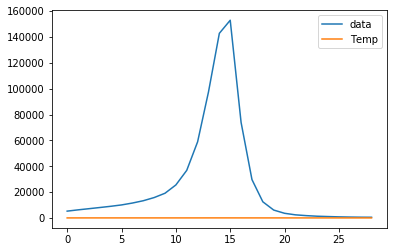

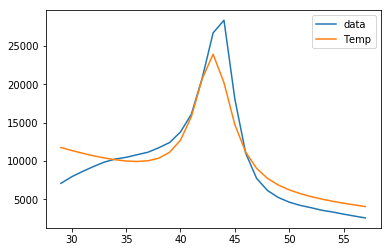

In [252]:
p0 = [
        1e2,   2e2, 1e5,   2e5,
        0.1, 2, 14,                 # Voigt
        1,1, 0.01, 0.05, # RooCMS
        0.1, 2, 43,                 # Voigt
        1, 1, 1, 0.04, # RooCMS
        ]

x = np.arange(0,len(DATA_PASS))
plt.figure()
plt.plot(DATA[:len(DATA_PASS)],label = 'data')
#plt.plot(Temp(*p0)[:len(DATA_PASS)],label = model(p0))
#plt.plot(Temp(*p0)[:len(DATA_PASS)],label='Temp')
plt.plot(Temp(*p0)[:len(DATA_PASS)],label='Temp')
plt.legend()

x = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
plt.figure()
plt.plot(x,DATA[len(DATA_FAIL):len(DATA_FAIL)*2],label = 'data')
#plt.plot(Temp(*p0)[:len(DATA_PASS)],label = model(p0))
#plt.plot(Temp(*p0)[:len(DATA_PASS)],label='Temp')
plt.plot(x,Temp(*p0)[len(DATA_FAIL):len(DATA_FAIL)*2],label='Temp')
plt.legend()

In [253]:
def OptYield(P0,model,index = 0,Ni=0,Nf=2e6,step=100,Plot=True):
    mod = []
    lambP = np.arange(Ni,Nf,step = step) #LAMB 0


    for p1 in lambP:
        P0[index] = p1
        mod.append(model(P0))
        
    if Plot:
        plt.figure()
        plt.plot(lambP,mod)
        ax = plt.gca()
        ax.set_yscale('log')

    return lambP[np.argmin(mod)]

[500000.0, 20000.0, 10000.0, 40000.0, 0.1, 2, 14, 1, 1, 0.01, 0.05, 0.1, 2, 43, 3, 3, 0.01, 0.05]
True


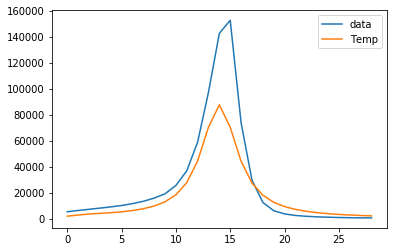

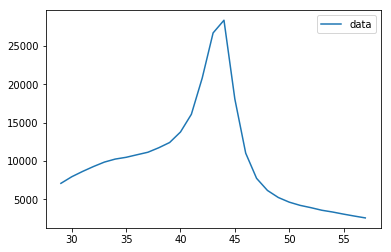

In [254]:
FitType = 'Voigt_CMS'
if FitType == 'Voigt_CMS':   
    p0 = [
            5e5,   2e4, 1e4,   4e4,
            0.1, 2, 14,                 # Voigt
            1,1, 0.01, 0.05, # RooCMS
            0.1, 2, 43,                 # Voigt
            3, 3, 0.01, 0.05, # RooCMS
            ]

    Bounded = (
                (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
                (0.01,20),(0.01,20),(0,30),
                (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-100,100),
                (0.01,20),(0.01,20),(0,60),
                (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-100,100),
              )

    Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail, \
                    sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                    sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail: \
                    TVoigt_CMS(
                                NSigPass, NBkgPass, NSigFail,NBkgFail, \
                                sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                                sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail, \
                                MCPass = MC_PASS_S[:len(DATA_PASS)], MCFail = MC_FAIL_S[:len(DATA_PASS)]
                              ) 

#model  = lambda x0:CHI2(DATA=DATA[:len(DATA_PASS)],Temp=Temp,*x0)        
#model  = lambda x0:NLL(DATA=DATA[:len(DATA_PASS)],Temp=Temp,*x0)        
model  = lambda x0:NLL(DATA=DATA[:len(DATA_PASS)],Temp=Temp(*x0)[:len(DATA_PASS)])
'''
for k in [1,3,0,2]:
    #Opt = OptYield(model = model,P0= p0,index = k, Plot=False)
    Opt = OptYield(model = model,P0= p0,index = k, Plot=True)
    print(k,Opt)
    p0[k] = Opt
'''
print(p0)
x = np.arange(0,len(DATA_PASS))
plt.figure()
plt.plot(x,DATA[:len(DATA_PASS)],label = 'data')
plt.plot(x,Temp(*p0)[:len(DATA_PASS)],label='Temp')
#plt.plot(x,Temp[:len(DATA_PASS)],label='Temp')
plt.legend()


x = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
plt.figure()
plt.plot(x,DATA[len(DATA_FAIL):len(DATA_FAIL)*2],label = 'data')
#plt.plot(x,Temp(*p0)[len(DATA_FAIL):len(DATA_FAIL)*2],label='Temp')
plt.legend()


singleFit = True
#singleFit = False
if singleFit:
    fitResult = minimize(model,
                         p0,
                         method = 'L-BFGS-B',
                         #method = "CG",
                         bounds = Bounded
                        )
    fitSucess = fitResult.success
    FIT = fitResult.x
    print(fitSucess)
else:
    FIT = Fit(  i,j,
                MC['Pass']['DYJets'][0][j][i], MC['Pass']['WJets'][0][j][i],
                MC['Fail']['DYJets'][0][j][i], MC['Fail']['WJets'][0][j][i],
                Data['Pass'][0][j][i]        , Data['Fail'][0][j][i],
                Temp = Temp,
                p0 = p0, Bounded = Bounded,
                Type   = FitType,
                Print  = True,
                #Print  = False,
                TryMax = 20,
                )  

In [46]:
singleFit = True
#singleFit = False
if singleFit:
    fitResult = minimize(model,
                         p0,
                         method = 'L-BFGS-B',
                         bounds = Bounded
                        )
    fitSucess = fitResult.success
    FIT = fitResult.x
    print(fitSucess)
else:
    FIT = Fit(i,j,
            MC['Pass']['DYJets'][0][j][i], MC['Pass']['WJets'][0][j][i],
            MC['Fail']['DYJets'][0][j][i], MC['Fail']['WJets'][0][j][i],
            Data['Pass'][0][j][i]        , Data['Fail'][0][j][i],
            Temp = Temp,
            p0 = p0, Bounded = Bounded,
            #FIT, Bounded,
            Type   = FitType,
            Print  = True,
            TryMax = 100,
            )  



True


499999.9950529485 [ 1.11317024  1.1098074  14.06290407] 
 19999.997220980287 [2.64979797e+01 2.21746294e-01 1.00000000e-02 2.25496598e+00]


NameError: name 'P0' is not defined

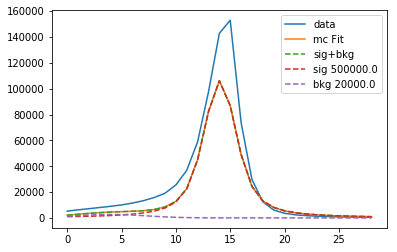

In [47]:


xs = np.arange(0,len(Data['Pass'][0][j][i]))
xc = np.arange(0,len(Data['Pass'][0][j][i]))*binMult+60


p0 = FIT  


if FitType == "Voigt_Exp":
    argVoigt = p0[4:7]
    argExp   = p0[7:9]
    NSig = p0[0]
    NBkg = p0[1]
    
    SIG = NSig*(Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt)))
    BKG = NBkg*(RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp)))
elif FitType == "Voigt_CMS":
    argVoigt = p0[4:7]
    argExp   = p0[7:11]

    NSig = p0[0]
    NBkg = p0[1]

    SIG = NSig*Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
    BKG = NBkg*RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp))


print(NSig,argVoigt,'\n',NBkg, argExp)


plt.plot(xs,      DATA[:len(DATA_PASS)], label =    'data')
plt.plot(xs,Temp(*p0)[:len(DATA_PASS)], label =  'mc Fit')
plt.plot(xs,   SIG+BKG, label = 'sig+bkg', linestyle = '--')
plt.plot(xs,       SIG, label =     'sig '+str(round(NSig)), linestyle = '--')
plt.plot(xs,       BKG, label =     'bkg '+str(round(NBkg)), linestyle = '--')
plt.legend()

P0[i][j] = FIT

 Plotting i0 j0
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i1 j0
--- Fitting


/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide


--- Plotting Pass
--- Plotting Fail
 Plotting i2 j0
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i3 j0
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i4 j0
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i5 j0
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i0 j1
--- Fitting


/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


--- Plotting Pass
--- Plotting Fail
 Plotting i1 j1
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i2 j1
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i3 j1
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i4 j1
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i5 j1
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i0 j2
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i1 j2
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i2 j2
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i3 j2
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i4 j2
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i5 j2
--- Fitting


/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]


--- Plotting Pass
--- Plotting Fail
 Plotting i0 j3
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i1 j3
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i2 j3
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i3 j3
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i4 j3
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i5 j3
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i0 j4
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i1 j4
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i2 j4
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i3 j4
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i4 j4
--- Fitting


/home/jcordero/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


--- Plotting Pass
--- Plotting Fail
 Plotting i5 j4
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i0 j5
--- Fitting
--- Plotting Pass
--- Plotting Fail
 Plotting i1 j5
--- Fitting
--- Plotting Pass
--- Plotting Fail


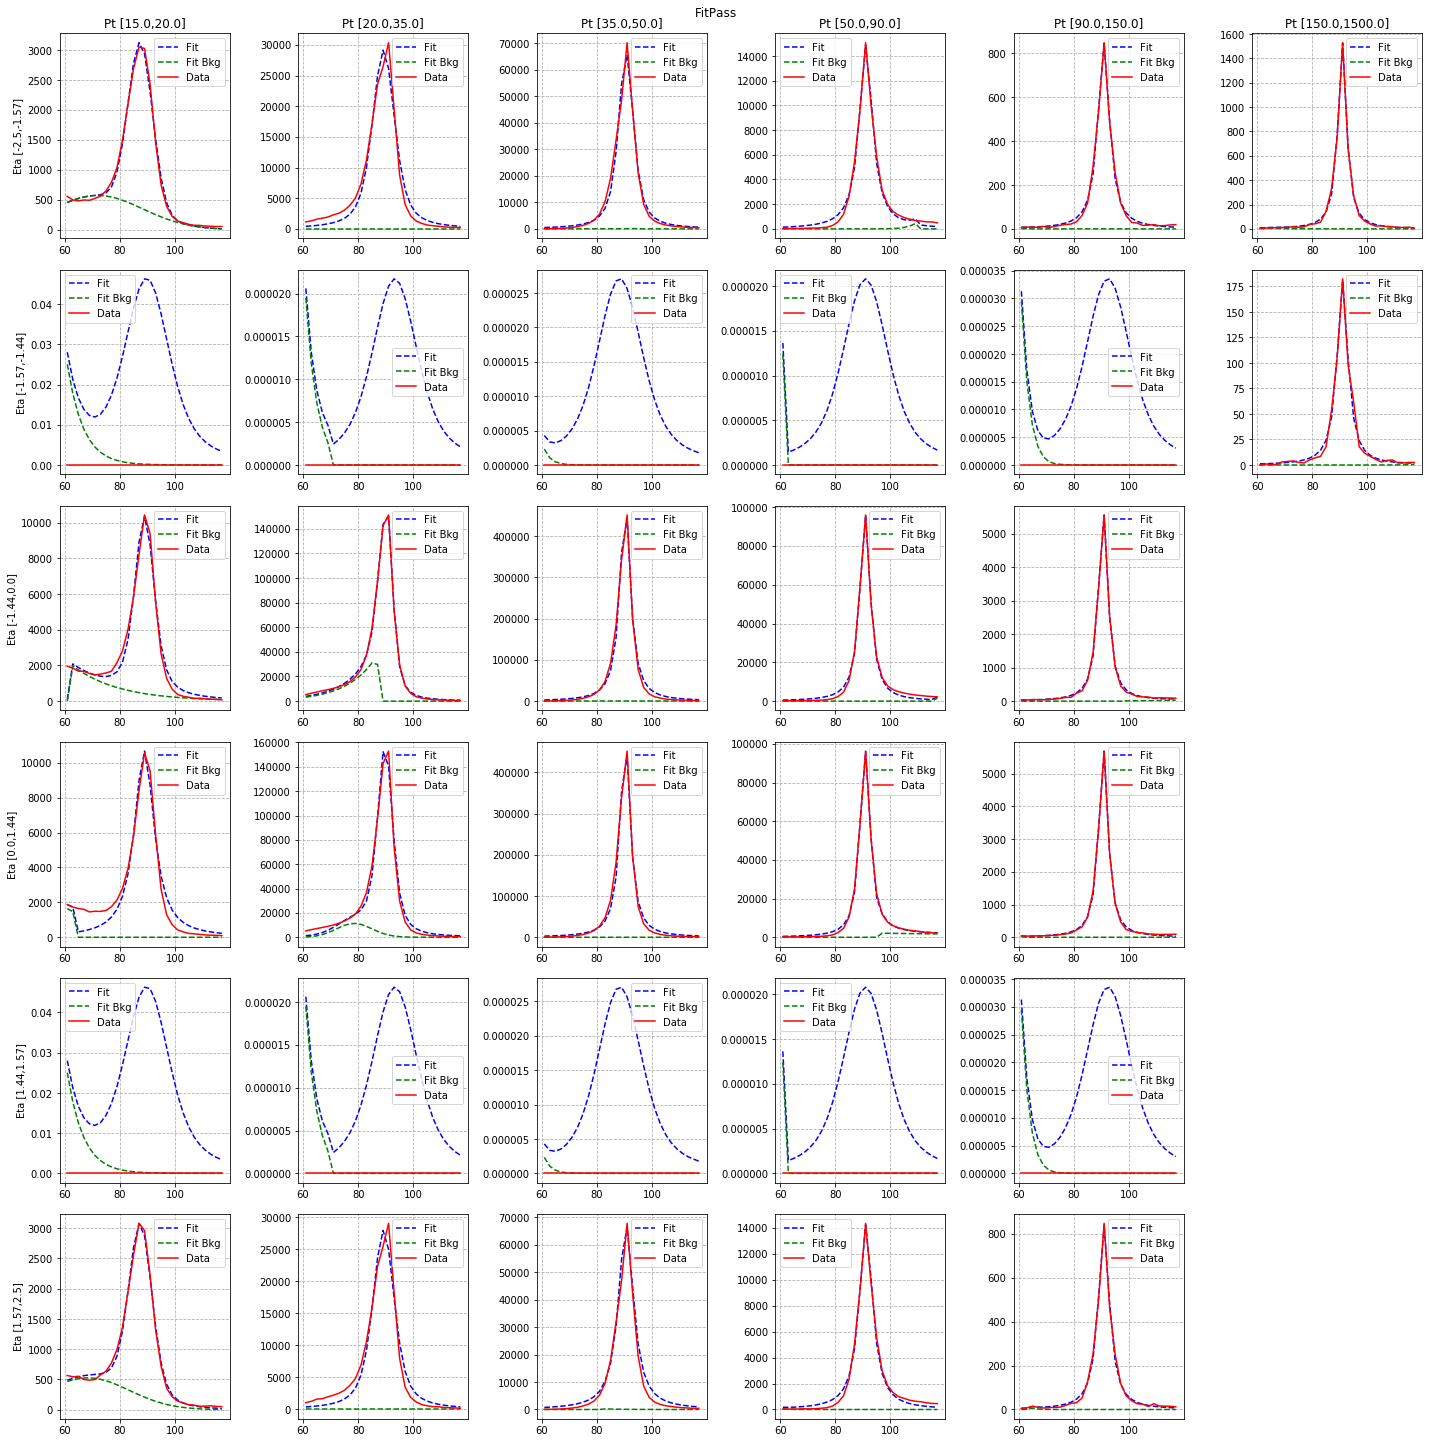

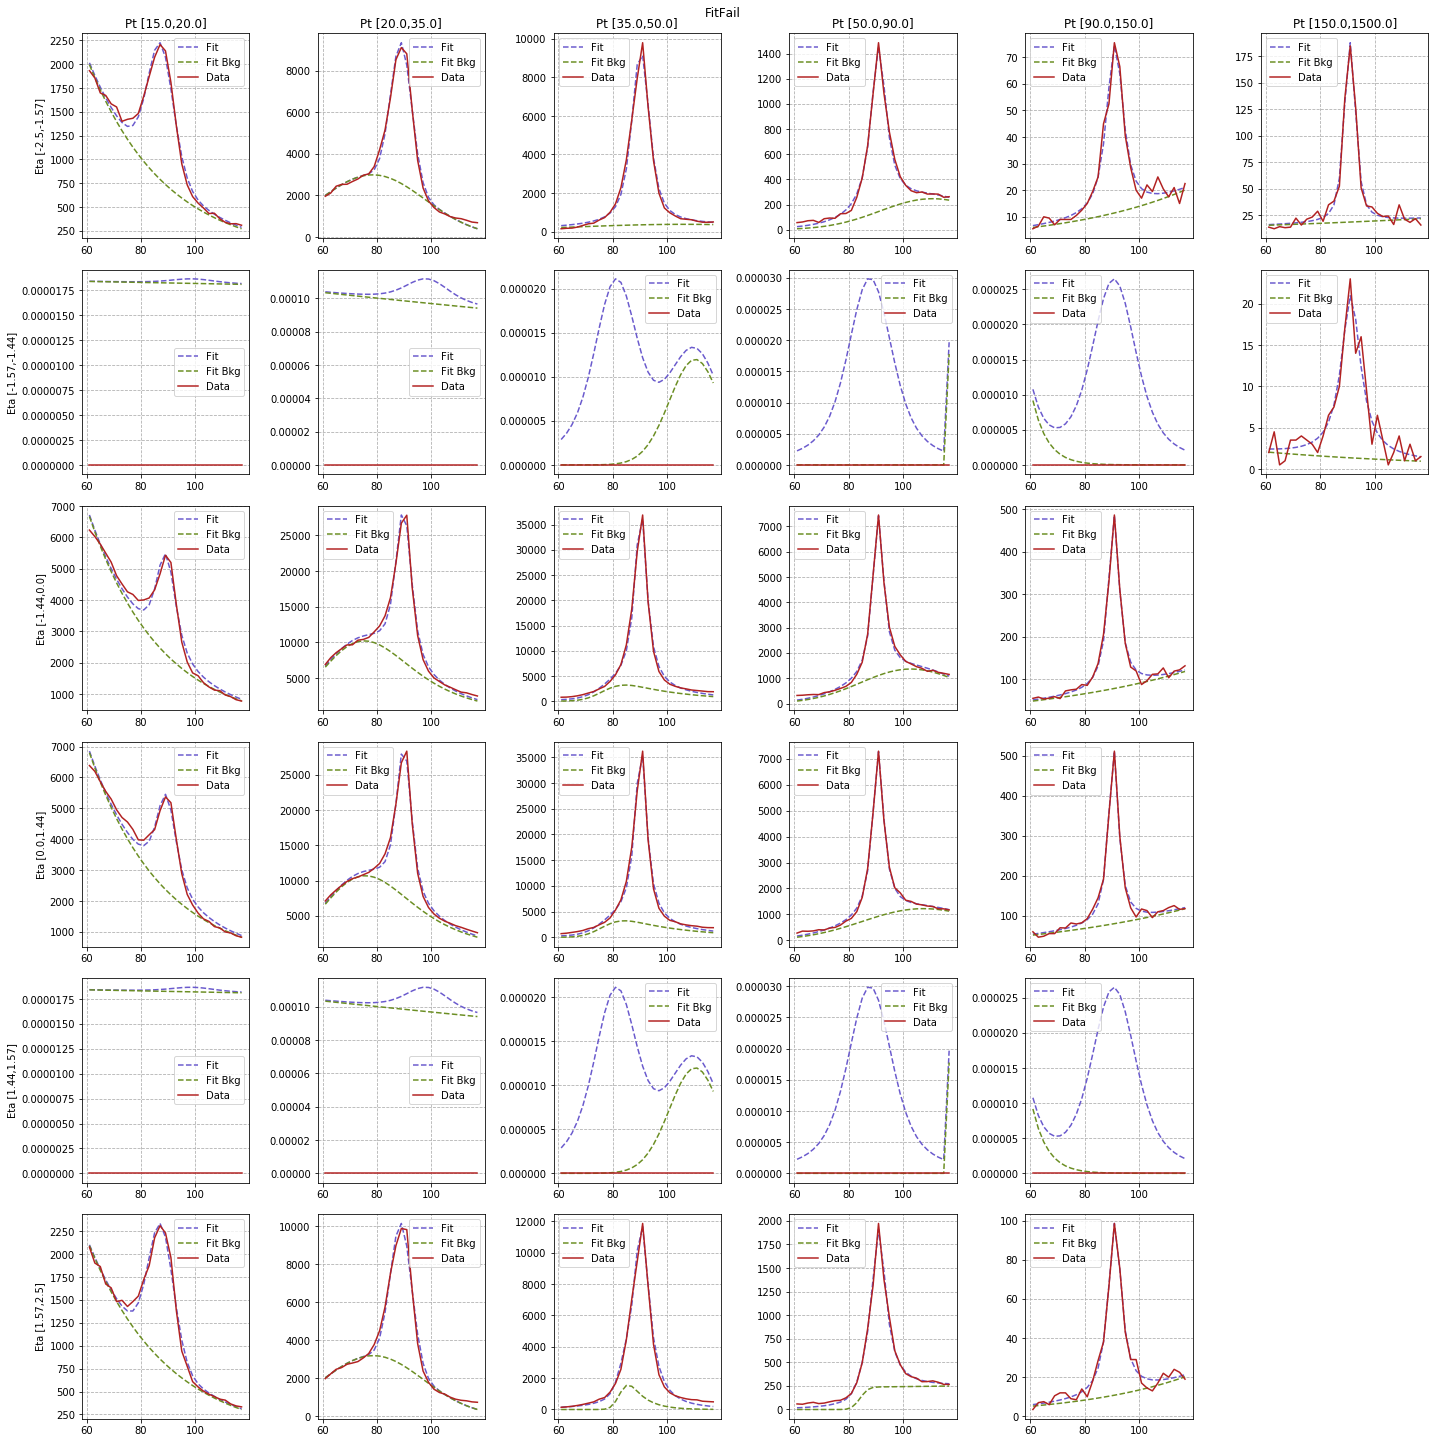

In [255]:
###################################

#FitType = 'Voigt_Exp'
#FitType = 'Voigt_CMS'
FitType = 'Voigt_Curve'

###################################      
    
etaBinsEBEE    = [[0,1.4442],[1.566,2.5]]
etaBins,ptBins = BinFormat(etaBins), BinFormat(ptBins)
etaNBin,ptNBin = len(etaBins),len(ptBins)

eff = {}

fit = []
fig  =  plt.figure(1,figsize=(20,20))
fig1 =  plt.figure(2,figsize=(20,20))

for j in np.arange(ptNBin):
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
    eff[j] = {}
    for i in np.arange(len(etaBINS)):
        ij = ptNBin*i + (j+1)     
        IJ = i + (j*etaNBin)
        
        print(' Plotting i'+str(i)+' j'+str(j))
        

        
        if   FitType == 'MC_Exp':
            p0 = [
                    1e5,   1e3, 1e4,   1e3,
                    1, 0.2, 1,   0.2,
                    1, 0.2, 1,   0.2
                    ]

            Bounded = ((0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
                       (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),
                       (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf))

            Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail,      \
                                alphaPass, betaPass, peakPass, gammaPass,   \
                                alphaFail, betaFail, peakFail, gammaFail:   \
                                T(NSigPass, NBkgPass, NSigFail,NBkgFail,    \
                                  alphaPass, betaPass, peakPass, gammaPass, \
                                  alphaFail, betaFail, peakFail, gammaFail, \
                                  MCPass = MC_PASS_S, MCFail = MC_FAIL_S)    
        elif FitType == 'Voigt_Exp':
            p0 = [
                    1e3,   1e5, 5e3,   1e5,
                    0.1, 0.1, 14,
                    0.03, 0,
                    0.1, 0.1, 14,
                    0.03, 0,
                    ]
            Bounded = (
                        (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
                        (0.01,4),(0.01,4),(0,40),
                        (-10,10),(0,np.inf),
                        (0.01,4),(0.01,4),(0,40),
                        (-10,10),(0,np.inf),
                      )

            Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail,             \
                            sigPass, GammaPass, meanPass, lambdaPass, xPass,   \
                            sigFail, GammaFail, meanFail, lambdaFail, xFail:   \
                            TVoigt_Test(NSigPass, NBkgPass, NSigFail,NBkgFail, \
                                        sigPass, GammaPass, meanPass,          \
                                        lambdaPass, xPass,                     \
                                        sigFail, GammaFail, meanFail,          \
                                        lambdaFail, xFail,                     \
                                        MCPass = MC_PASS_S, MCFail = MC_FAIL_S)    
        elif FitType == "Voigt_noSig":
            p0 = [
                    1e5,   1e5,
                    0.1, 0.1, 14,
                    0.03, 0,
                    0.1, 0.1, 14,
                    0.03, 0,
                    ]
            Bounded = (
                        (0,np.inf),(0,np.inf),
                        (0.01,4),(0.01,4),(0,40),
                        (-10,10),(0,np.inf),
                        (0.01,4),(0.01,4),(0,40),
                        (-10,10),(0,np.inf),
                      )
            Temp = lambda   NBkgPass,NBkgFail,                                 \
                            sigPass, GammaPass, meanPass, lambdaPass, xPass,   \
                            sigFail, GammaFail, meanFail, lambdaFail, xFail:   \
                            TVoigt_noSig(NBkgPass,NBkgFail,                     \
                                        sigPass, GammaPass, meanPass,          \
                                        lambdaPass, xPass,                     \
                                        sigFail, GammaFail, meanFail,          \
                                        lambdaFail, xFail,                     \
                                        MCPass = MC_PASS_S, MCFail = MC_FAIL_S)    
        elif FitType == 'Voigt_CMS':   
            p0 = [
                    1e2,   2e2, 1e2,   4e2,
                    0.1, 2, 14,                 # Voigt
                    1,1, 0.01, 0.05, # RooCMS
                    0.1, 2, 43,                 # Voigt
                    1, 1, 0.01, 0.05, # RooCMS
                    ]

            Bounded = (
                        (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
                        (0.01,20),(0.01,20),(0,30),
                        (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),
                        (0.01,20),(0.01,20),(0,60),
                        (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),
                      )

            Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail, \
                            sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                            sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail: \
                            TVoigt_CMS(NSigPass, NBkgPass, NSigFail,NBkgFail, \
                                       sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                                       sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail, \
                                       MCPass = MC_PASS_S, MCFail = MC_FAIL_S) 
        elif FitType == 'Voigt_x':
            p0 = [ 2.10010102e+04,  3.34421859e+03,  9.73858331e+03,  2.53360134e+04,
                    2.44107828e+00,  8.74878690e-01,  1.30304384e+01,  7.13139484e+00,
                   -1.30489487e+01,  1.99560639e+01,  4.61991664e-02,  2.34434414e+00,
                    9.74446121e-01,  4.20876696e+01,  3.00000000e+00,  3.00000000e+00,
                    1.97578463e+02,  7.12292034e-02]
            BoundedFit = [
                           [0,0,0,0,
                            0.01,0.01,0,
                            -np.inf,-np.inf,-np.inf,-np.inf,
                            0.01,0.01,30,
                            -np.inf,-np.inf,-np.inf,-np.inf],
                           [np.inf,np.inf,np.inf,np.inf,
                            5,5,30,
                            np.inf,np.inf,np.inf,np.inf,
                            5,5,60,
                            np.inf,np.inf,np.inf,np.inf,
                            ]
                          ]
        elif FitType == 'Voigt_Curve':
            if i == 1 or i == 4:
                pPass = np.array(pPass)*0
                pPass[4] = 20
                pFail = np.array(pFail)*0
                pFail[4] = 20

            
            if   j == 0:
                pPass = [
                        4e4,   5e3, 
                        0.1, 2, 13,       # Voigt
                        1,1, 0.01, 0.09,  # RooCMS
                        ]

                pFail = [
                        1.5e3,   5e4, 
                        1, 1, 44,       # Voigt
                        1,1, 0.01, 0.09,  # RooCMS
                        ]
            elif j == 1:
                pPass = [
                        5e5,   5e3, 
                        0.1, 2, 13,       # Voigt
                        10,0.01, 10, 0.09,  # RooCMS
                        ]

                pFail = [
                        5e4,   5e4, 
                        1, 1, 44,           # Voigt
                        20,0.01, 20, 0.09,  # RooCMS
                        ]
            elif j == 2:
                pPass = [
                        6e5,   5e3, 
                        0.1, 2, 13,       # Voigt
                        10,0.01, 10, 0.09,  # RooCMS
                        ]

                pFail = [
                        1.5e5,   5e4, 
                        1, 1, 44,           # Voigt
                        20,0.01, 20, 0.09,  # RooCMS
                        ]
            elif j == 3:
                if i == 0 or i == 5:
                    pPass = [
                            3e5,   7e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            8e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
            elif j == 4:
                pPass = [
                        1e4,  1e2,  
                        0.1,  2, 15,  
                        1,1, 1.15814356e+02,1,
                        ] 

                pFail = [
                        1e3,  1e2,  
                        0.1,  2, 43,  
                        1,  1, 1.15814356e+02,1,
                        ] 

                BoundedFit = [
                           [0,0,
                            0.0001,0.0001,10,
                            -np.inf,-np.inf,-np.inf,-np.inf,],
                           [np.inf,np.inf,
                            3,3,48,
                            np.inf,np.inf,np.inf,np.inf,
                            ]
                          ]
            elif j == 5:
                if i == 0:
                    pPass = [
                            5e3,  1e2,  
                            0.1,  2, 15,  
                            1,1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  2, 43,  
                            1,  1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            5e2,  1e1,  
                            0.1,  2, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  1e1,  
                            0.1,  2, 43,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
        
        BoundedFit = [
                   [0,0,
                    0,0,10,
                    #-np.inf,-2,-np.inf,-2],
                    0,-np.inf,-np.inf,-1],
                   [np.inf,np.inf,
                    3,3,48,
                    70,np.inf,np.inf,1,
                    ]
                    ]                
        #model  = lambda x0:CHI2(DATA=DATA,Temp=Temp(*x0))
        #for k in [1,3,0,2]:
        #    Opt = OptYield(P0= p0,model = model,index = k,Plot=False)
        #    p0[i] = Opt

        print('--- Fitting')    
        '''
        FIT = Fit(  i,j,
                    MC['Pass']['DYJets'][0][j][i], MC['Pass']['WJets'][0][j][i],
                    MC['Fail']['DYJets'][0][j][i], MC['Fail']['WJets'][0][j][i],
                    Data['Pass'][0][j][i]        , Data['Fail'][0][j][i],
                    Temp = Temp,
                    p0 = p0, Bounded = Bounded,
                    Type   = FitType,
                    Print  = True,
                    #Print  = False,
                    TryMax = 20,
                    )  
        ''';
        '''
        FIT = Fit_Curve(i,j,
                        MC['Pass']['DYJets'][0][j][i], MC['Pass']['WJets'][0][j][i],
                        MC['Fail']['DYJets'][0][j][i], MC['Fail']['WJets'][0][j][i],
                        Data['Pass'][0][j][i]        , Data['Fail'][0][j][i],
                        p0 = p0, Bounded = BoundedFit,
                        )
        '''
        FitP, FitF,FitPSig, FitFSig = Fit_Curve(
                                                DATA_PASS = Data['Pass'][0][j][i],
                                                DATA_FAIL = Data['Fail'][0][j][i],
                                                pPass = pPass,pFail = pFail,
                                                Bounded = BoundedFit,
                                                )
        ####################################################################################
        PassFail = 'Pass'
        xs = np.arange(0,len(Data[PassFail][0][j][i]))

        if   FitType == 'MC_Exp':
            expParam = tuple(FIT[4:8])
            NSig = FIT[0]
            NBkg = FIT[1]

            SIG = MC[PassFail]['DYJets'][0][j][i]/np.sum(MC[PassFail]['DYJets'][0][j][i])
            BKG = RooCMSShape(xc,*expParam)/np.sum(RooCMSShape(xc,*expParam))
            
            eff[j][i] = FIT[0]/(FIT[0]+FIT[2])
        elif FitType == 'Voigt_Exp':
            argVoigt = FIT[4:7]
            argExp   = FIT[7:9]

            NSig = FIT[0]
            NBkg = FIT[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = Exp  (xs, *argExp)  /np.sum(Exp  (xs, *argExp))
            
            eff[j][i] = FIT[0]/(FIT[0]+FIT[2])
        elif FitType == 'Voigt_CMS':
            argVoigt = FIT[4:7]
            argExp   = FIT[7:11]

            NSig = FIT[0]
            NBkg = FIT[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp))
            
            eff[j][i] = FIT[0]/(FIT[0]+FIT[2])
        elif FitType == 'Voigt_x':
            argVoigt = FIT[4:7]
            argExp   = FIT[7:11]

            NSig = FIT[0]
            NBkg = FIT[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp))
            
            eff[j][i] = FIT[0]/(FIT[0]+FIT[2])
        elif FitType == 'Voigt_Curve':
            argVoigt = FitP[2:5]
            argExp   = FitP[5:9]

            NSig = FitP[0]
            NBkg = FitP[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp))

            eff[j][i] = FitP[0]/(FitP[0]+FitF[0])
        plt.figure(1)
        ax = plt.subplot(len(etaBins),len(ptBins),ij)
        color = ['b','g','r']

        print('--- Plotting Pass')    
        PlotFitting(
                    ax,
                    NSig = NSig, NBkg = NBkg,
                    DATA = Data[PassFail][0][j][i],
                    SIG  = SIG,
                    BKG  = BKG,
                    eta  = etaBINS[i], pt = ptBins[j],
                    color = color,
                   )
        '''
        ax.text(60,max(SIG)*0.5,
                 'NSig = '+str(round(NSig))+' +/- '+str(FitPSig[0]),
                 fontsize = 2)
        ax.text(60,max(SIG)*0.5,
                 'NBkg = '+str(round(NBkg))+' +/- '+str(FitPSig[1]),
                 fontsize = 2)
        '''
        
        if np.isnan(eff[j][i]):
            eff[j][i] = 0.0
        ####################################################################################
        PassFail = 'Fail'
        xs = np.arange(len(Data[PassFail][0][j][i]),len(Data[PassFail][0][j][i])*2)

        if   FitType == 'MC_Exp':
            expParam = tuple(FIT[8:12])

            NSig = FIT[2]
            NBkg = FIT[3]

            SIG = MC[PassFail]['DYJets'][0][j][i]/np.sum(MC[PassFail]['DYJets'][0][j][i])
            BKG = RooCMSShape(xc,*expParam)/np.sum(RooCMSShape(xc,*expParam))   
        elif FitType == 'Voigt_Exp':
            argVoigt = FIT[9:12]
            argExp   = FIT[12:14]

            NSig = FIT[2]
            NBkg = FIT[3]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = Exp  (xs, *argExp)  /np.sum(Exp  (xs, *argExp))
        elif FitType == 'Voigt_CMS':
            argVoigt = FIT[11:14]
            argExp   = FIT[14:18]

            NSig = FIT[2]
            NBkg = FIT[3]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)/np.sum(RooCMSShape(xs, *argExp))   
        elif FitType == 'Voigt_x':
            argVoigt = FIT[11:14]
            argExp   = FIT[14:18]

            NSig = FIT[2]
            NBkg = FIT[3]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)/np.sum(RooCMSShape(xs, *argExp))  
        elif FitType == 'Voigt_Curve':
            argVoigt = FitF[2:5]
            argExp   = FitF[5:9]

            NSig = FitF[0]
            NBkg = FitF[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp))

        print('--- Plotting Fail')    
        plt.figure(2)
        ax1 = plt.subplot(len(etaBins),len(ptBins),ij)
        color = ['slateblue','olivedrab','firebrick']

        PlotFitting(
                    ax1,
                    NSig = NSig, NBkg = NBkg,
                    DATA = Data[PassFail][0][j][i],
                    SIG  = SIG,
                    BKG  = BKG,
                    eta  = etaBINS[i], pt = ptBins[j],
                    color = color,
                   )
        '''
        ax.text(60,max(SIG)*0.5,
                 'NSig = '+str(round(NSig))+' +/- '+str(FitFSig[0]),
                 fontsize = 2)
        ax.text(60,max(SIG)*0.5,
                 'NBkg = '+str(round(NBkg))+' +/- '+str(FitFSig[1]),
                 fontsize = 2)
        '''
        ####################################################################################
        
        
fig.tight_layout()        
fig1.tight_layout()        

     
fig.suptitle("FitPass",y=1)
fig1.suptitle("FitFail",y=1) 

fig .savefig(figpath+"FitPass_Exp.png")        
fig1.savefig(figpath+"FitFail_Exp.png")     
plt.show()

In [257]:
path = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Efficiency/zee/"
fileOut = TFile(path+"eff_photon_data_VoigtCMS.root","recreate")
tree = TTree("eff_photon","eff_photon")


ptBins, etaBins = BinFormat(ptBins,Type = 'edges'),BinFormat(etaBins,Type = 'edges')
ptNBins, etaNBins = len(ptBins)-1 , len(etaBins)-1

hist2d = TH2F("EGamma_eff","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)


etaBins = BinFormat(etaBins)
tree.Branch("eff",hist2d,"TH2F")
for j in range(ptNBins):
    hist2d.GetZaxis().SetRangeUser(0.6,1.1)
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
        
    if len(etaBINS) > 2:
        for i in np.arange(len(etaBINS)):
            hist2d.SetBinContent(int(j)+1, int(i)+1, eff[j][i])
            tree.Fill()
    else:
        for i in range(len(etaBins)):
            if np.abs(np.average(etaBins[i])) > 1.566:
                EFF = eff[j][0]
            elif np.abs(np.average(etaBins[i])) < 1.4442:
                EFF = eff[j][1]
                I = 2
            else:
                EFF = 0
            #print(j,i,I,eff[j][I])
            hist2d.SetBinContent(int(j)+1, int(i)+1, EFF)
            tree.Fill()
    
    
fileOut.Write()
fileOut.Close()

In [260]:
fileOut = TFile("sf_photon.root","recreate")
tree = TTree("sf_photon","sf_photon")

ptBins, etaBins = BinFormat(ptBins,Type='edges'),BinFormat(etaBins,Type='edges')
ptNBins,etaNBins = len(ptBins)-1, len(etaBins)-1
#ptNBins,etaNBins = len(ptBins)-2, len(etaBins)-1

hist2d = TH2F("EGamma_sf","SF",
              ptNBins ,ptBins,
              etaNBins,etaBins)

tree.Branch("sf",hist2d,"TH2F")
etaBins = BinFormat(etaBins)

for j in range(ptNBins):
    #hist2d.GetXaxis().SetRangeUser(0,200)
    hist2d.GetZaxis().SetRangeUser(0.6,1.2)
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
        
    if len(etaBINS) > 2:
        for i in np.arange(len(etaBINS)):
            hist2d.SetBinContent(int(j)+1, int(i)+1, eff[j][i]/effMC[j][i])
            tree.Fill()
    else:
        for i in range(len(etaBins)):
            if np.abs(np.average(etaBins[i])) > 1.566:
                EFF = eff[j][0]/effMC[j][0]
                #EFF = effMC[j][0]
            elif np.abs(np.average(etaBins[i])) < 1.4442:
                EFF = eff[j][1]/effMC[j][1]
                #EFF = effMC[j][1]
                I = 2
            else:
                EFF = 0
            #print(j,i,I,eff[j][I])
            hist2d.SetBinContent(int(j)+1, int(i)+1, EFF)
            tree.Fill()
    
    
fileOut.Write()
fileOut.Close()

In [113]:
dir(hist2d)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

# -------------------------------------------------------

In [ ]:
def Voigt_CMS_x(
                xc,
                NSigPass, NBkgPass, NSigFail,NBkgFail, 
                sigPass, GammaPass, meanPass,
                alphaPass, betaPass, peakPass, gammaPass,
                sigFail, GammaFail, meanFail,
                alphaFail, betaFail, peakFail, gammaFail,
                MCPass, MCFail
                ):
    #x = np.arange(0,len(MCPass))
    x = xc[:len(MCPass)]
    argPass      = alphaPass, betaPass, peakPass, gammaPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(NSigPass, NBkgPass, 
                         Voigt(x,*argVoigtPass)  , RooCMSShape(x,*argPass))) 
    
    
    #x = np.arange(len(MCPass),len(MCPass)*2)
    x = xc[len(MCPass):len(MCPass)*2]
    argFail      = alphaFail, betaFail, peakFail, gammaFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(NSigFail, NBkgFail, 
                         Voigt(x,*argVoigtFail) , RooCMSShape(x,*argFail)))
    
    
    Temp = np.array(Pass + Fail )
    return Temp


In [764]:
def Voigt_CMS(
                xc,
                NSig, NBkg, 
                sig, Gamma, mean,
                alpha, beta, peak, gamma,
                ):
    x = xc
    arg      = alpha, beta, peak, gamma
    argVoigt = sig, Gamma, mean
    Temp = list(Template(NSig, NBkg, 
                         Voigt(x,*argVoigt) , RooCMSShape(x,*arg)))
    
    
    return np.array(Temp)


In [51]:
PassYield = {}
FailYield = {}
FitPass = {}
FitFail = {}

---------------------- i: 0 j: 3 -------------------------
Signal:  63734.178016583006 1437.8040269411902   ratio:  0.02255938762663712
Fail:  6487.57815402745 928.0971499630687   ratio:  0.14305756754343088


/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide


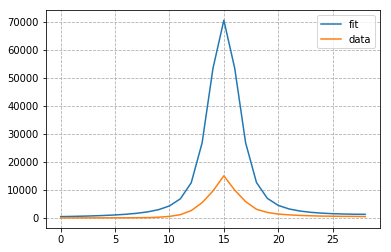

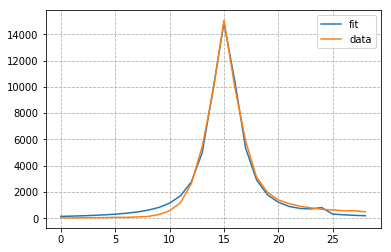

---------------------- i: 1 j: 3 -------------------------
Signal:  0.000240234200232149 7.048881712393002e-05   ratio:  0.2934170782337133
Fail:  0.0003472519342308001 0.00010192446695646312   ratio:  0.29351734838349175


/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


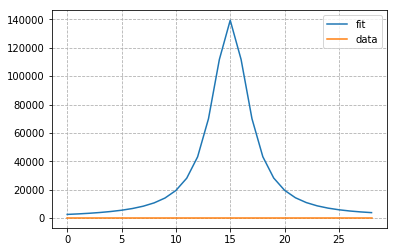

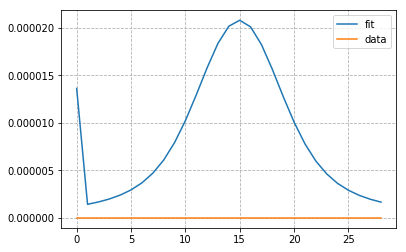

---------------------- i: 2 j: 3 -------------------------
Signal:  324211.643063395 6687.321996507775   ratio:  0.020626409136084493
Fail:  22466.88619233109 2041.6672159776715   ratio:  0.09087450741948298


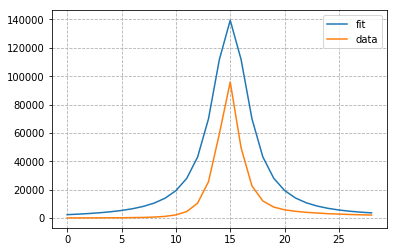

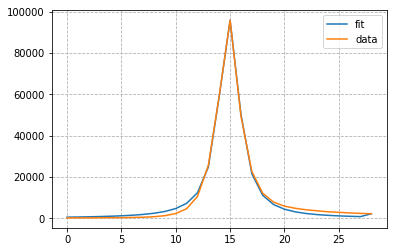

---------------------- i: 3 j: 3 -------------------------
Signal:  314268.35746984684 4780.397829789556   ratio:  0.015211196788236061
Fail:  23667.89393607393 1027.5198044837978   ratio:  0.04341407846676553


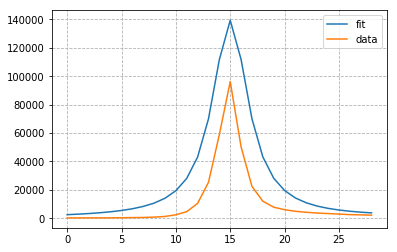

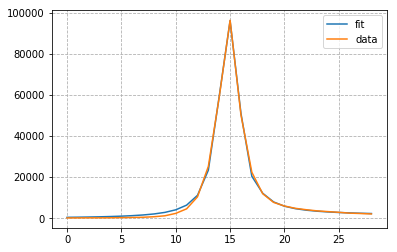

---------------------- i: 4 j: 3 -------------------------
Signal:  0.000240234200232149 7.048881712393002e-05   ratio:  0.2934170782337133
Fail:  0.0003472519342308001 0.00010192446695646312   ratio:  0.29351734838349175


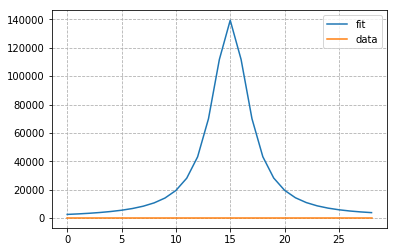

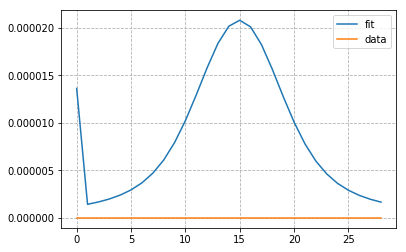

---------------------- i: 5 j: 3 -------------------------
Signal:  60497.6228977351 1543.6320951344564   ratio:  0.025515582616259237
Fail:  7679.592016610067 741.647729807536   ratio:  0.09657384509534335


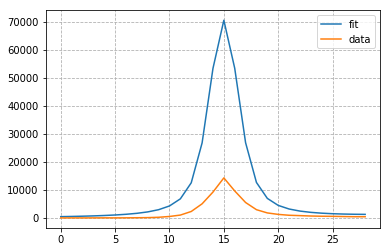

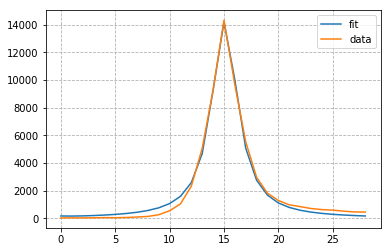

In [133]:

PlotBefore = True
#PlotBefore = False


for j in range(6):
    if j != 3: continue
    PassYield[j] = {}
    FailYield[j] = {}
    FitPass[j] = {}
    FitFail[j] = {}
    for i in range(6):
        print('---------------------- i: '+str(i)+' j: '+str(j)+' -------------------------')
        
        MC_PASS_S = MC['Pass']['DYJets'][0][j][i]#, MC['Pass']['WJets'][0][IJ],
        MC_FAIL_S = MC['Fail']['DYJets'][0][j][i]#, MC['Fail']['WJets'][0][IJ],
        DATA_PASS = Data['Pass'][0][j][i]
        DATA_FAIL = Data['Fail'][0][j][i] 
        DATA = np.array(list(DATA_PASS) + list(DATA_FAIL))

        #####################################################
        VoigtCMS = lambda x,*x0 : Voigt_CMS(
                                            x,
                                            NSig  =  x0[0], NBkg  =  x0[1],
                                            sig   =  x0[2], Gamma =  x0[3], mean =  x0[4],
                                            alpha =  x0[5], beta  =  x0[6], peak =  x0[7], gamma = x0[8], 
                                            )
        x = np.arange(0,len(DATA_PASS))


        ##########################################################################
        ##########################################################################
        
        if i == 1 or i == 4:
            pPass = np.array(pPass)*0
            pPass[4] = 20
            pFail = np.array(pFail)*0
            pFail[4] = 20
            
        if   j == 0:
            pPass = [
                    4e4,   5e3, 
                    0.1, 2, 13,       # Voigt
                    1,1, 0.01, 0.09,  # RooCMS
                    ]

            pFail = [
                    1.5e3,   5e4, 
                    1, 1, 44,       # Voigt
                    1,1, 0.01, 0.09,  # RooCMS
                    ]

            BoundedFit = [
                       [0,0,
                        0.0001,0.0001,10,
                        -np.inf,-np.inf,-np.inf,-np.inf,],
                       [np.inf,np.inf,
                        3,3,48,
                        np.inf,1,np.inf,np.inf,
                        ]
                      ]
        elif j == 1:
            pPass = [
                    5e5,   5e3, 
                    0.1, 2, 13,       # Voigt
                    10,0.01, 10, 0.09,  # RooCMS
                    ]

            pFail = [
                    5e4,   5e4, 
                    1, 1, 44,           # Voigt
                    20,0.01, 20, 0.09,  # RooCMS
                    ]
        elif j == 2:
            pPass = [
                    6e5,   5e3, 
                    0.1, 2, 13,       # Voigt
                    10,0.01, 10, 0.09,  # RooCMS
                    ]

            pFail = [
                    1.5e5,   5e4, 
                    1, 1, 44,           # Voigt
                    20,0.01, 20, 0.09,  # RooCMS
                    ]
        elif j == 3:
            if i == 0 or i == 5:
                pPass = [
                        3e5,   7e3, 
                        #0.1, 2, 15,       # Voigt
                        1, 1, 15,       # Voigt
                        13,0.01, 10, -0.09,  # RooCMS
                        ]

                pFail = [
                        9e3,   4e3, 
                        1, 1, 44,           # Voigt
                        40,0.01, 20, -0.09,  # RooCMS
                        ]
            else:
                pPass = [
                        8e5,   5e3, 
                        0.1, 2, 15,       # Voigt
                        13,0.01, 10, -0.09,  # RooCMS
                        ]

                pFail = [
                        9e3,   4e3, 
                        1, 1, 44,           # Voigt
                        40,0.01, 20, -0.09,  # RooCMS
                        ]
        elif j == 4:
            pPass = [
                    1e4,  1e2,  
                    0.1,  2, 15,  
                    1,1, 1.15814356e+02,1,
                    ] 

            pFail = [
                    1e3,  1e2,  
                    0.1,  2, 43,  
                    1,  1, 1.15814356e+02,1,
                    ] 
        elif j == 5:
            if i == 0:
                pPass = [
                        5e3,  1e2,  
                        0.1,  2, 15,  
                        1,1, 1.15814356e+02,1,
                        ] 

                pFail = [
                        1e3,  1e2,  
                        0.1,  2, 43,  
                        1,  1, 1.15814356e+02,1,
                        ] 
            elif i == 1:
                pPass = [
                        5e2,  1e1,  
                        0.1,  2, 15,  
                        10,0.1, 1.15814356e+02,0.1,
                        ] 

                pFail = [
                        1e2,  1e1,  
                        0.1,  2, 43,  
                        10,  0.1, 1.15814356e+02,0.1,
                        ] 
            
        
        BoundedFit = [
                   [0,0,
                    0,0,10,
                    0,-np.inf,-np.inf,-1],
                   [np.inf,np.inf,
                    3,3,48,
                    70,np.inf,np.inf,1,
                    ]
                    ]
        ##################################
        if PlotBefore:
            plt.figure()
            
            xFit = np.arange(0,len(DATA_PASS))
            plt.plot(xFit,VoigtCMS(xFit,*pPass),label='fit')
            plt.plot(xFit,       DATA_PASS,label='data')
            plt.legend()
            plt.grid(linestyle='--')
            '''
            print(pFail,max(VoigtCMS(xFit,*pFail)))
            xFit = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
            plt.plot(xFit,VoigtCMS(xFit,*pFail),label='fit')
            plt.plot(xFit,         DATA_FAIL,label='data')
            plt.legend()
            plt.grid(linestyle='--')
            '''
        '''
        print(len(p0),len(BoundedFit))
        Fits = Fit_Curve(i,j,
                        MC['Pass']['DYJets'][0][j][i], MC['Pass']['WJets'][0][j][i],
                        MC['Fail']['DYJets'][0][j][i], MC['Fail']['WJets'][0][j][i],
                        Data['Pass'][0][j][i]        , Data['Fail'][0][j][i],
                        p0 = p0, Bounded = BoundedFit,
                        )
        Fits = [Fits,0]
        ''';
        ##---------------------------------------

        xFit = np.arange(0,len(DATA_PASS))
        Fits = curve_fit(
                        f     = VoigtCMS,
                        xdata = xFit,
                        ydata = DATA_PASS,
                        p0 = pPass,
                        #method = 'lm',
                        method = 'trf',
                        #method = 'dogbox',
                        bounds = BoundedFit,
                        )

        FitsPass = Fits[0]
        sigs = np.sqrt(np.diag(Fits[1]))
        print('Signal: ',Fits[0][0],sigs[0],'  ratio: ',sigs[0]/Fits[0][0])

        xFit = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
        Fits = curve_fit(
                        f      = VoigtCMS,
                        xdata  = xFit,
                        ydata  = DATA_FAIL,
                        p0     = pFail,
                        #method = 'lm',
                        method = 'trf',
                        #method = 'dogbox',
                        bounds = BoundedFit,
                        )
        FitsFail = Fits[0]

        sigs = np.sqrt(np.diag(Fits[1]))
        print('Fail: ',Fits[0][0],sigs[0],'  ratio: ',sigs[0]/Fits[0][0])
        #for i in range(len(Fits[0])):
        #    print(Fits[0][i],sigs[i])


        ###-----------------
        plt.figure()
        
        xFit = np.arange(0,len(DATA_PASS))
        plt.plot(xFit,VoigtCMS(xFit,*FitsPass),label='fit')
        plt.plot(xFit,       DATA_PASS,label='data')
        plt.legend()
        plt.grid(linestyle='--')
        '''
        xFit = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
        plt.plot(xFit,VoigtCMS(xFit,*FitsFail),label='fit')
        plt.plot(xFit,         DATA_FAIL,label='data')
        plt.legend()
        plt.grid(linestyle='--')
        '''
        FitPass[j][i] = FitsPass
        FitFail[j][i] = FitsFail
        PassYield[j][i] =  FitsPass[0]
        FailYield[j][i] =  FitsFail[0]
        
        eff[j][i] = PassYield[j][i]/(FailYield[j][i] + PassYield[j][i])
        ##########################################################################
        ##########################################################################
        plt.show()
        

In [125]:
print(len(Fits[0]),len(Fits[1]))

9 9


7679.592016610067 550041.355128672
4102.827409203322 455192.7820900058
1.617587750487688e-05 77728404.36240907
1.5725705205788787 0.04383763368050458
44.05701022296054 0.001997775601407904
40.59760335500054 0.3248819840145022
0.6049908757007967 0.12729424428791467
1356.3479467579784 1.3488135006017823e+19
-0.0029928906881116967 0.0007142195171879698
